Dokonczyc RNN
UNET testowac na innych zbiorach
Transformer
Podstawowe eksperymenty z RSA
Runtime - jak rozwiazac to zagadnienie???
Zestawienie porównania wyników modeli
Latex - zacząć pisać od końca
1. Przeglad aktualnych rozwiazan
2. Implementacja
3. Rezultaty

# RNN for R-peak detection using the pytorch library

In [3]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from customLib.vis import *
from customLib.preprocess import *
from customLib.peak_detection import *
from customLib.dataset import read_dataset
from customLib.config import fantasia_path, mitbih_path
from models.models import LSTM
from customLib.print_model_parameters import print_model_parameters
from customLib.metrics import print_metrics
from torch.utils.data import DataLoader
from models.datasets import ECGDataset
from tqdm import tqdm
from customLib.peak_detection import correct_prediction_according_to_aami
# from torchsummary import summary

KeyboardInterrupt: 

In [ ]:
LSTM_HIDDEN_SIZE = 32
EPOCHS = 50
BATCH_SIZE = 100
LR = 1e-2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# laod and preprocess dataset
# x, y = load_physionet_ecgs(path=mitbih_path, annotation_file_extension="atr", force_new=True, window_in_seconds=10, expand=False, denoise=True)

In [ ]:
path = mitbih_path + "\\dataset\\raw"
# x_train, y_train, x_test, y_test, x_val, y_val = split_dataset(path=mitbih_path, x=x, y=y, shuffle=False, split_ratio=0.8, is_validation_set=True)
x_train, y_train, x_test, y_test, x_val, y_val = read_dataset(path=path, is_validation_set=True)

x_train = np.expand_dims(x_train, 2)
y_train = np.expand_dims(y_train, 2)

x_test = np.expand_dims(x_test, 2)
y_test = np.expand_dims(y_test, 2)

x_val = np.expand_dims(x_val, 2)
y_val = np.expand_dims(y_val, 2)

In [ ]:
num_pos = np.sum(y_train[0])
num_neg = len(y_train[0]) - num_pos
pos_weight = int(num_neg / num_pos / 5)
pos_weight = torch.tensor([17], dtype=torch.float32).to(device)
print(f"Positive label weight (R-peak): {(pos_weight.item()):.5f}")

Positive label weight (R-peak): 17.00000


In [ ]:
model = LSTM(input_dim=1, hidden_size=LSTM_HIDDEN_SIZE, lr=LR, loss_pos_weight=pos_weight, checkpoint_path="./checkpoints/raw_ecgs/lstm") #input_size == hidden features size (1-lead ECG)
# model.load_state_dict(torch.load(".\\checkpoints\\lstm\\lstm_epoch_50_acc_99.80_f1_0.97.pt"))

Training will be performed with: cuda:0


e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
print_model_parameters(model)

Layer lstm_1: 8960 parameters
Layer lstm_2: 25088 parameters
Layer dense: 65 parameters
Total params: 34113


====Epoch [1/50]====


 99%|█████████▉| 118/119 [00:22<00:00,  5.95it/s]

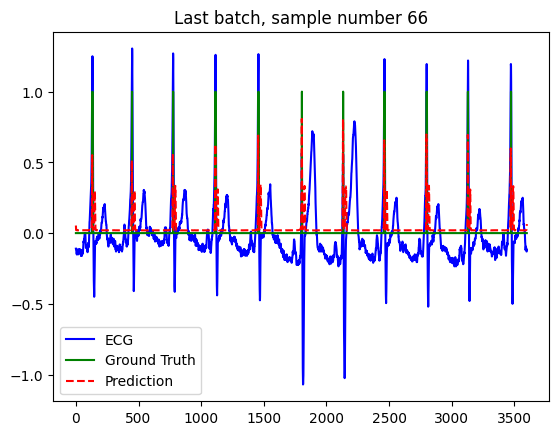

100%|██████████| 119/119 [00:23<00:00,  5.03it/s]


Learning rate:  [0.01]

Train Loss: 0.1942


KeyboardInterrupt: 

In [ ]:
model.train_model(x_train=x_train, y_train=y_train, epochs=EPOCHS, x_val=x_val, y_val=y_val, batch_size=BATCH_SIZE)

In [ ]:
model.test_model(x_test=x_test, y_test=y_test)

100%|██████████| 396/396 [00:03<00:00, 99.33it/s] 



Test Loss: 0.0515
test Weighted Accuracy: 0.99691
test F1 Score: 0.96473
test TPR: 0.99468
test FPR: 0.00086
test TNR: 0.99914
test FNR: 0.00532



In [ ]:
with open("./metrics/lstm.pkl", "wb") as f:
  pickle.dump(model.get_metrics(), f)

In [12]:
from customLib.vis import plot_metrics
import pickle

with open("./metrics/raw/st_res_net.pkl", "rb") as f:
  metrics = pickle.load(f)

In [ ]:
print_metrics(metrics, "all", 49)

In [13]:
plot_metrics(metrics)

In [ ]:
# load pretrained model
model = LSTM(input_dim=1, hidden_size=LSTM_HIDDEN_SIZE, lr=LR, loss_pos_weight=torch.Tensor([17]))
model.load_state_dict(torch.load(".\\checkpoints\\lstm\\raw_ecgs\\lstm_epoch_49_acc_95.49_f1_0.89.pt"))


Training will be performed with: cuda:0


e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\patry\AppData\Local\Temp\ipykernel_20200\2336796335.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `to

<All keys matched successfully>

In [ ]:
model.test_model(x_test=x_test, y_test=y_test)

100%|██████████| 396/396 [00:09<00:00, 42.61it/s]



Test Loss: 0.0495
test Weighted Accuracy: 0.95439
test F1 Score: 0.88758
test TPR: 0.90927
test FPR: 0.00049
test TNR: 0.99951
test FNR: 0.09073



### Testing with Fantasia and own dataset, both on preprocessed and raw dataset

In [ ]:
pos_weight = torch.Tensor([17]).to(device)

lstm = LSTM(input_dim=1, hidden_size=LSTM_HIDDEN_SIZE, lr=LR, loss_pos_weight=pos_weight)
lstm.load_state_dict(torch.load(".\\checkpoints\\lstm\\lstm_epoch_50_acc_99.71_f1_0.97.pt"))

raw_lstm = LSTM(input_dim=1, hidden_size=LSTM_HIDDEN_SIZE, lr=LR, loss_pos_weight=pos_weight)
raw_lstm.load_state_dict(torch.load(".\\checkpoints\\lstm\\raw_ecgs\\lstm_epoch_49_acc_95.49_f1_0.89.pt"))

Training will be performed with: cuda:0


e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Training will be performed with: cuda:0


C:\Users\patry\AppData\Local\Temp\ipykernel_10296\1563145667.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm.load_state_dict(torch.load(".\\checkpoints\\lstm\\lstm_

<All keys matched successfully>

In [ ]:
x = np.load(fantasia_path + "\\preprocessed\\downsampled\\x.npy")
y = np.load(fantasia_path + "\\preprocessed\\downsampled\\y.npy")

x_raw = np.load(fantasia_path + "\\preprocessed\\raw\\x.npy")
y_raw = np.load(fantasia_path + "\\preprocessed\\raw\\y.npy")

x_raw =  np.expand_dims(x_raw, 2)
y_raw = np.expand_dims(y_raw, 2)

x = np.expand_dims(x, 2)
y = np.expand_dims(y, 2)

In [ ]:
x_aidmed = np.load(".\\aidmed_ecgs\\preprocessed\\x.npy")
y_aidmed = np.load(".\\aidmed_ecgs\\preprocessed\\y.npy")

x_aidmed = np.expand_dims(x_aidmed, 2)
y_aidmed = np.expand_dims(y_aidmed, 2)

In [ ]:
def test_model(model, x_test, y_test, plot=False):
    test_dataset = ECGDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    running_loss = 0.0
    num_r_peaks = 0.0
    num_correct = 0.0

    all_outputs = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for i, (x_test, y_test) in tqdm(enumerate(test_loader), total=len(test_loader)):
            x, y = x_test.to(device), y_test.to(device)
            outputs = model(x)

            loss = model.criterion(outputs, y)
            running_loss += loss.item()

            outputs = torch.sigmoid(outputs)

            outputs = outputs.cpu().detach().numpy()
            y = y.cpu().detach().numpy()

            num_r_peaks += np.where(y == 1)[0].shape[0]
            num_correct += np.where((outputs > 0.5) & (y == 1))[0].shape[0]

            all_outputs.extend(outputs.flatten())
            all_labels.extend(y.flatten())

            ecg = x[0].cpu().detach().numpy().flatten()
            gt = y[0].flatten()
            pred = outputs[0].flatten()
            pred = (pred > 0.5).astype(np.int32)

            corrected_r_peaks = correct_prediction_according_to_aami(y_true=gt, y_pred=pred, sampling_rate=250)

            correct_r_peaks = np.where((corrected_r_peaks == 1) & (gt == 1))[0]
            false_positives = np.where((corrected_r_peaks == 1) & (gt == 0))[0]
            false_negatives = np.where((corrected_r_peaks == 0) & (gt == 1))[0]


            if len(false_positives) > 0 or len(false_negatives) > 0:
                gt_line = Line2D([0], [0], color='orange', label='Ground Truth', linestyle='-')
                prediction_line = Line2D([0], [0], color='blue', label='Prediction', linestyle='-')
                correct_line = Line2D([0], [0], color='green', label='Correct line', linestyle='--')
                error_fp = Line2D([0], [0], color='crimson', label='FP', linestyle='--')
                error_fn = Line2D([0], [0], color='darkviolet', label='FN', linestyle='--')

                fig, axs = plt.subplots(nrows=2)
                ax = axs[0]
                ax.plot(ecg)
                ax.legend(["ECG"])
                ax.grid()

                ax = axs[1]
                ax.plot(pred)
                ax.plot(gt)
                ax.grid()
                ax.legend(handles=[gt_line, correct_line, prediction_line, error_fp, error_fn])

                for correct in correct_r_peaks:
                    ax.axvline(correct, 0, 1, color='g', linestyle='--')
                for fp in false_positives:
                    ax.axvline(fp, 0, 1, color='fuchsia', linestyle='--', linewidth=2)
                for fn in false_negatives:
                    ax.axvline(fn, 0, 1, color='darkviolet', linestyle='--', linewidth=2)

                fig.set_size_inches(6,4)
                plt.show()
            
    all_outputs = np.array(all_outputs)
    all_labels = np.array(all_labels)
    y_pred_binary = (all_outputs > 0.5).astype(int)
    test_loss = running_loss / len(test_loader)
    print(f"\nTest Loss: {test_loss:.4f}")
    model.calculate_metrics(test_loss, all_labels, y_pred_binary, "test")

In [ ]:
test_model(lstm, x_test=x, y_test=y, plot=True)

  0%|          | 0/2774 [00:00<?, ?it/s]

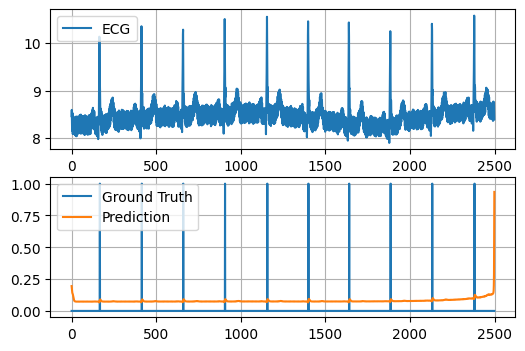

 10%|▉         | 275/2774 [00:10<01:38, 25.43it/s]

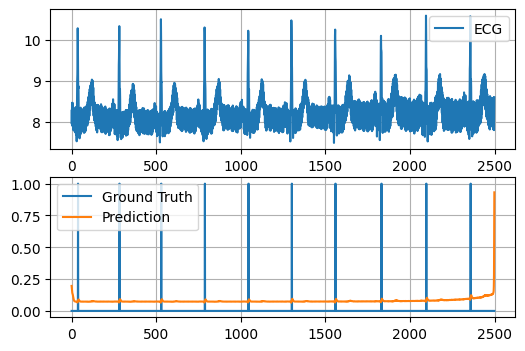

 20%|█▉        | 553/2774 [00:22<01:24, 26.18it/s]

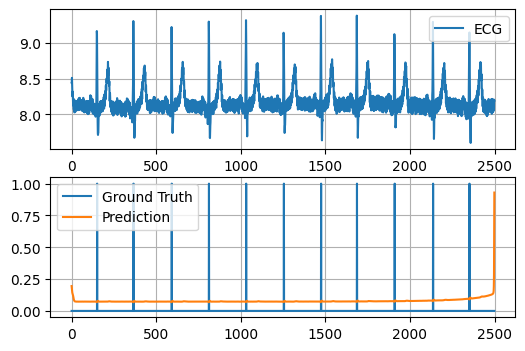

 30%|██▉       | 829/2774 [00:32<01:24, 22.93it/s]

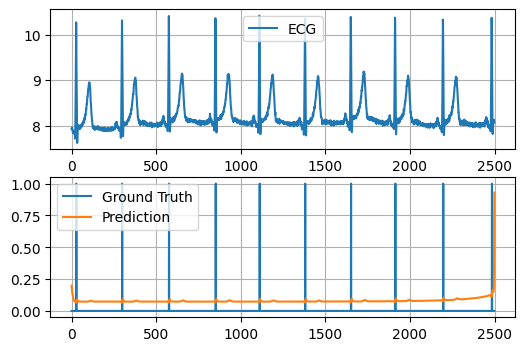

 40%|███▉      | 1106/2774 [00:43<00:59, 28.01it/s]

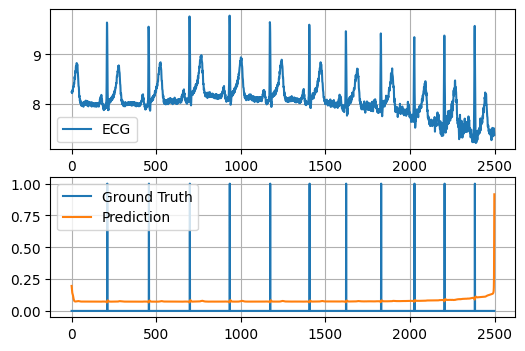

 50%|████▉     | 1382/2774 [00:54<00:52, 26.37it/s]

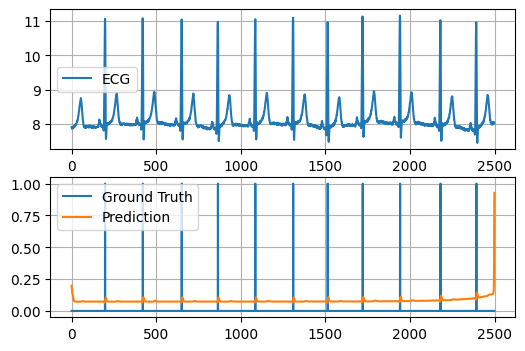

 60%|█████▉    | 1662/2774 [01:05<00:42, 26.25it/s]

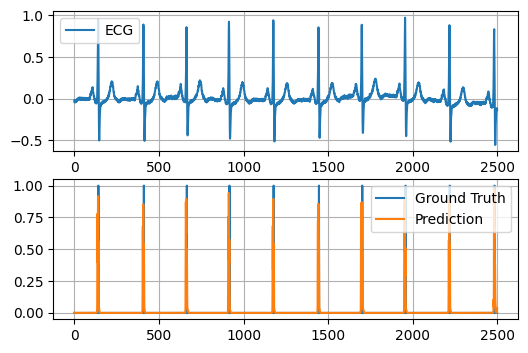

 70%|██████▉   | 1939/2774 [01:16<00:32, 25.43it/s]

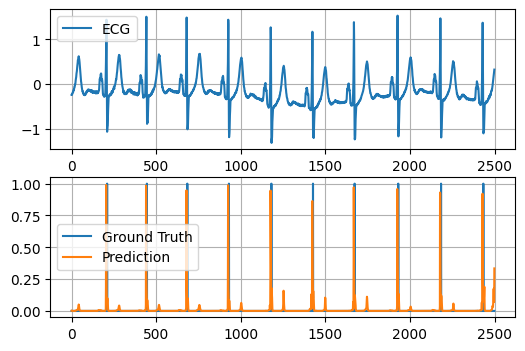

 80%|███████▉  | 2215/2774 [01:27<00:19, 28.45it/s]

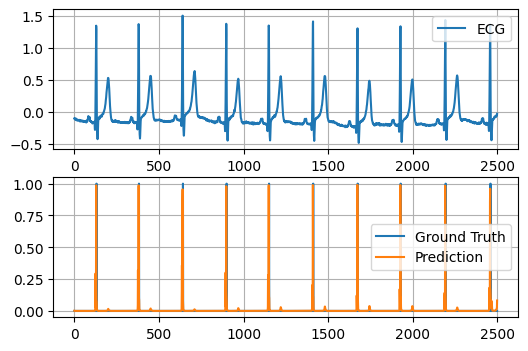

 90%|████████▉ | 2491/2774 [01:40<00:10, 26.60it/s]

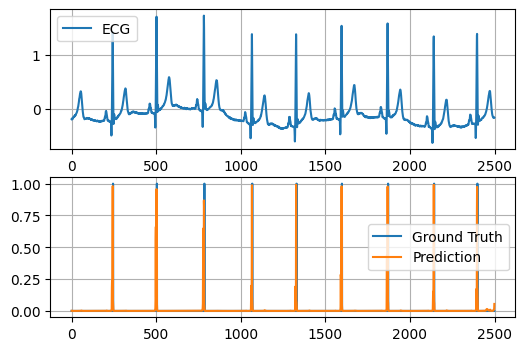

100%|█████████▉| 2769/2774 [01:52<00:00, 26.91it/s]

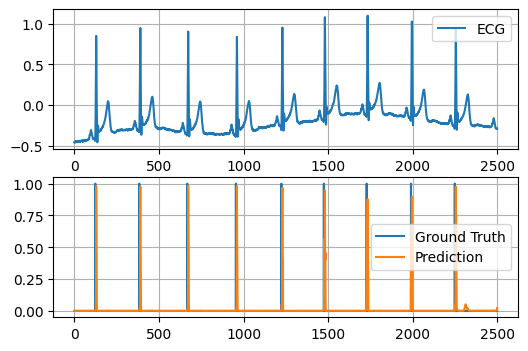

100%|██████████| 2774/2774 [01:52<00:00, 24.59it/s]



Test Loss: 0.2082
test Weighted Accuracy: 0.73834
test F1 Score: 0.54844
test TPR: 0.47775
test FPR: 0.00107
test TNR: 0.99893
test FNR: 0.52225



In [ ]:
test_model(raw_lstm, x_test=x_raw, y_test=y_raw, plot=True)

  0%|          | 0/2774 [00:00<?, ?it/s]

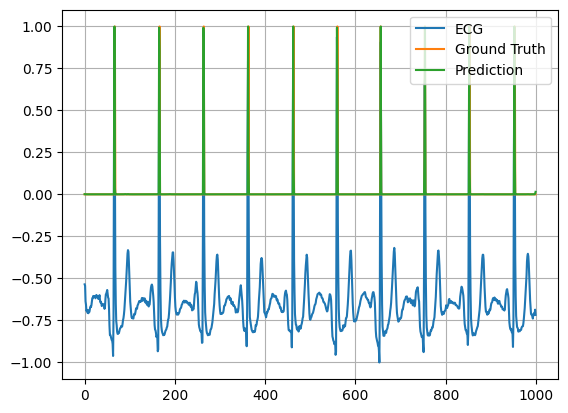

 10%|▉         | 267/2774 [00:03<00:23, 106.74it/s]

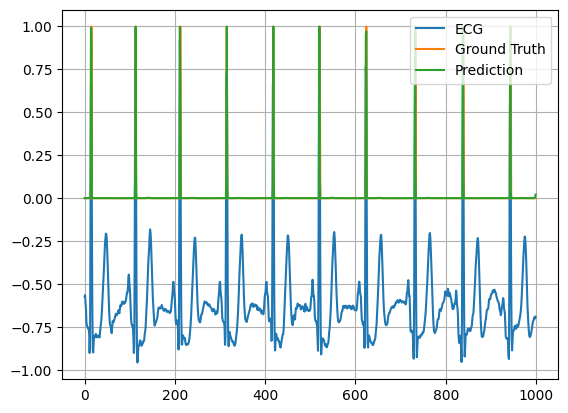

 20%|█▉        | 545/2774 [00:05<00:20, 107.79it/s]

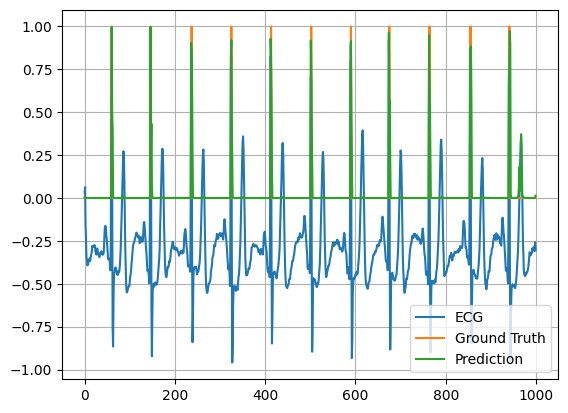

 30%|██▉       | 821/2774 [00:08<00:19, 99.82it/s] 

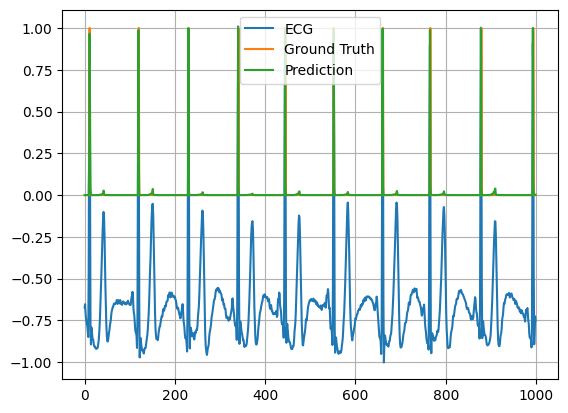

 40%|███▉      | 1107/2774 [00:11<00:14, 113.96it/s]

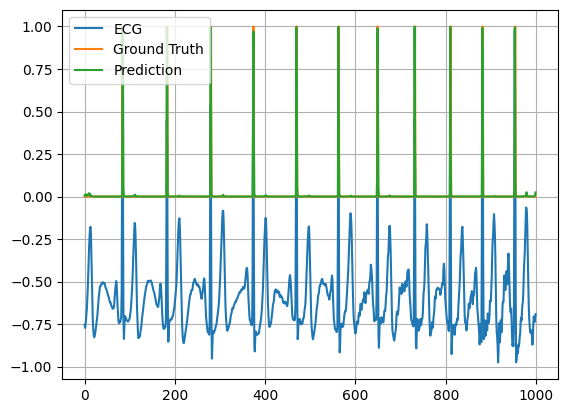

 50%|████▉     | 1383/2774 [00:14<00:12, 115.83it/s]

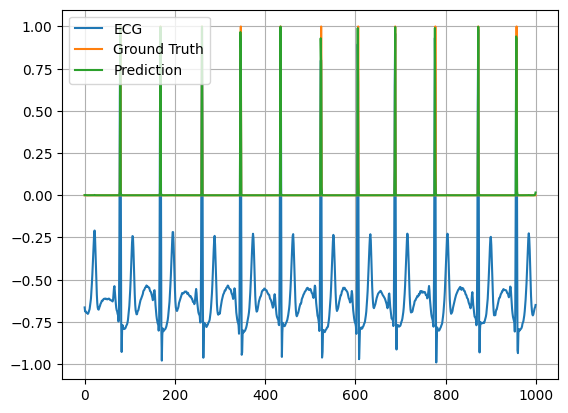

 60%|█████▉    | 1654/2774 [00:16<00:09, 114.02it/s]

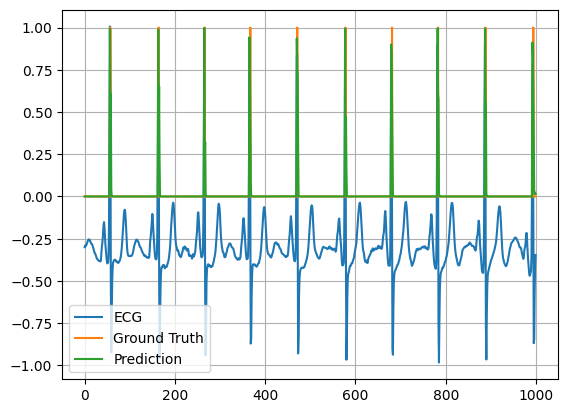

 69%|██████▉   | 1927/2774 [00:19<00:07, 113.00it/s]

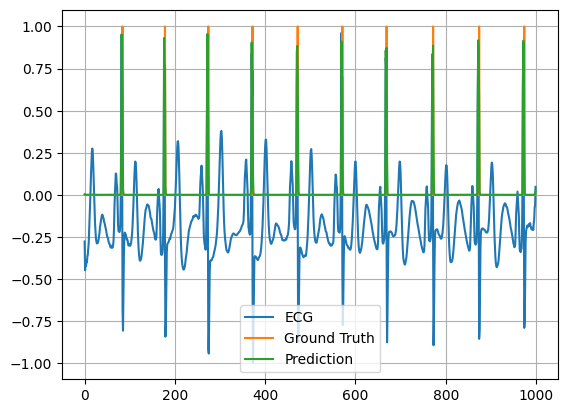

 79%|███████▉  | 2204/2774 [00:21<00:04, 122.07it/s]

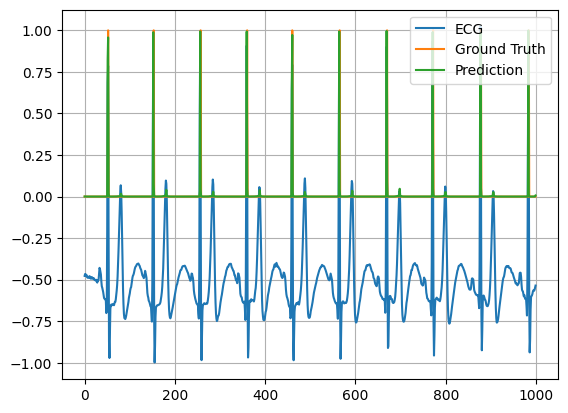

 90%|████████▉ | 2489/2774 [00:24<00:02, 125.26it/s]

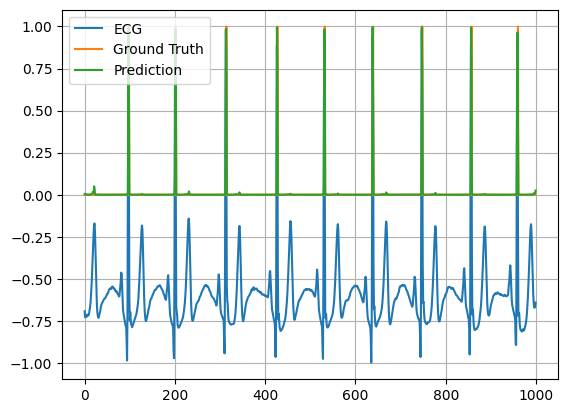

 99%|█████████▉| 2760/2774 [00:26<00:00, 122.41it/s]

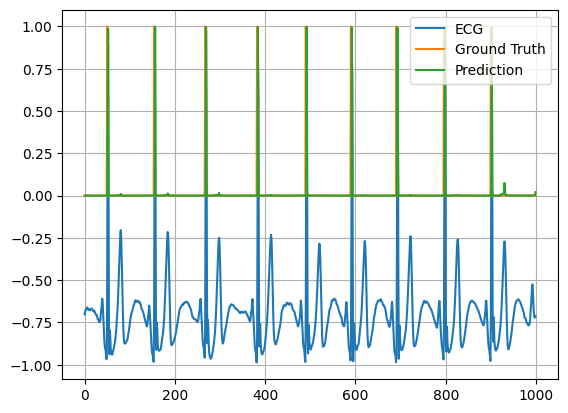

100%|██████████| 2774/2774 [00:27<00:00, 102.45it/s]



Test Loss: 0.3864
test Weighted Accuracy: 0.99958
test F1 Score: 0.98946
test TPR: 0.99938
test FPR: 0.00021
test TNR: 0.99979
test FNR: 0.00062



In [ ]:
# test_model(lstm, x, y, True)
lstm.test_model(x_test=x, y_test=y, plot=True)

  0%|          | 0/2774 [00:00<?, ?it/s]

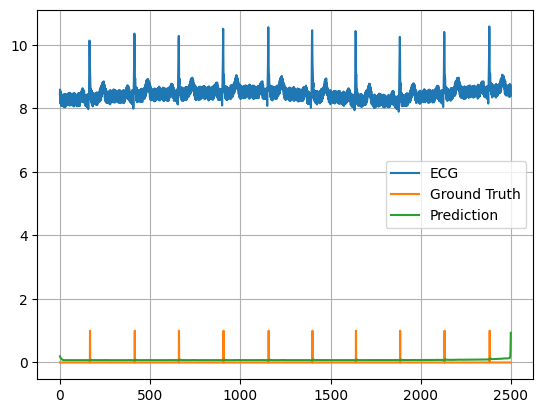

 10%|▉         | 275/2774 [00:10<01:29, 27.81it/s]

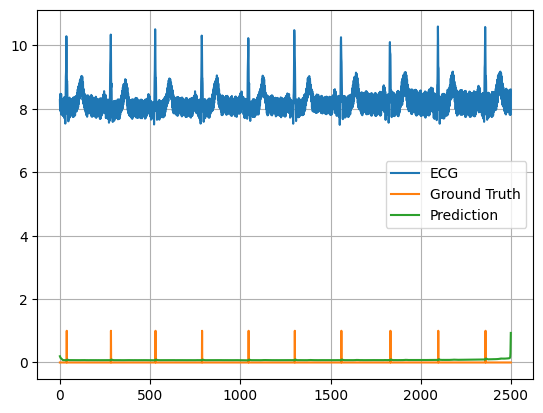

 20%|█▉        | 553/2774 [00:21<01:28, 25.13it/s]

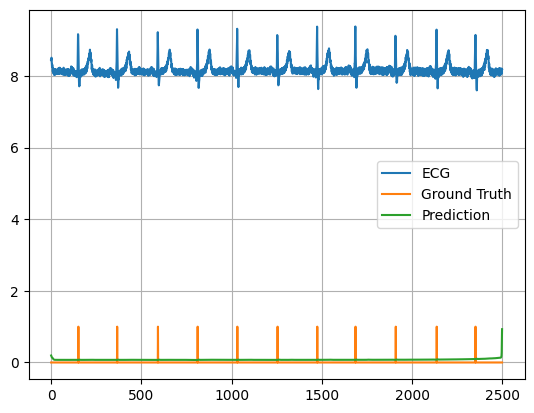

 30%|██▉       | 830/2774 [00:32<01:14, 26.24it/s]

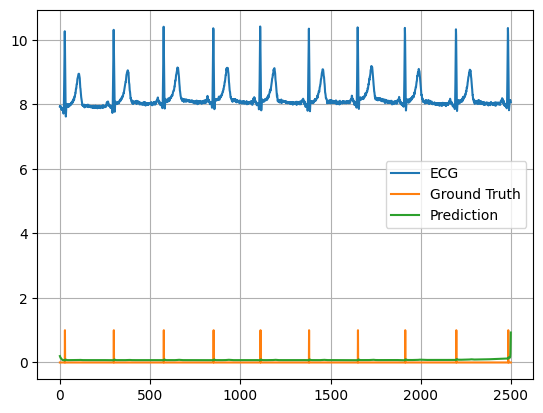

 40%|███▉      | 1107/2774 [00:43<00:58, 28.30it/s]

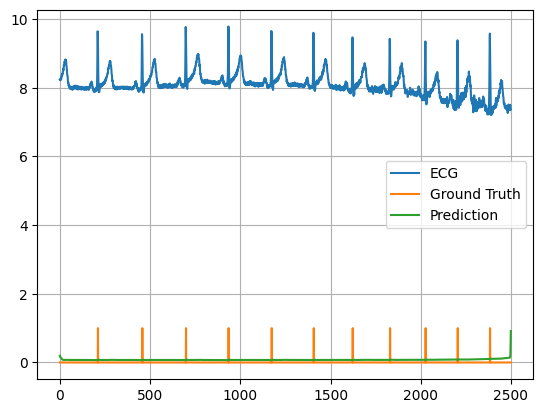

 50%|████▉     | 1384/2774 [00:53<00:50, 27.26it/s]

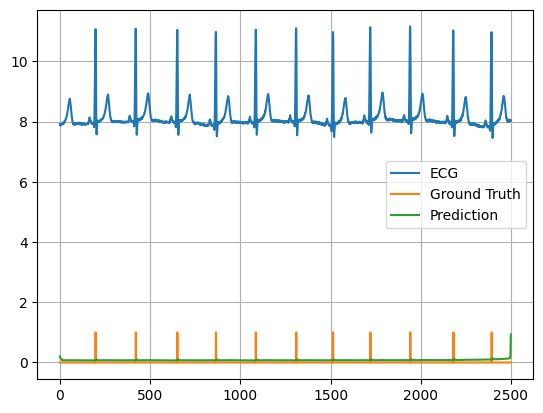

 60%|█████▉    | 1660/2774 [01:04<00:51, 21.74it/s]

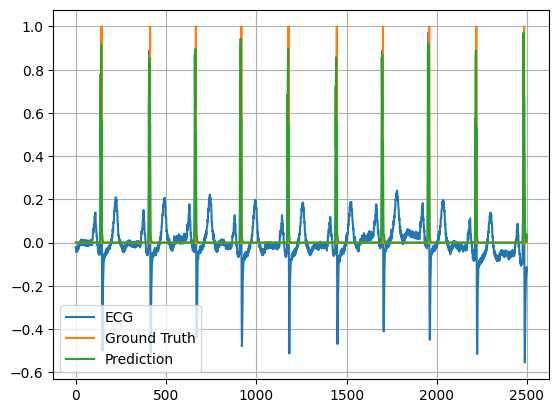

 70%|██████▉   | 1939/2774 [01:16<00:32, 26.01it/s]

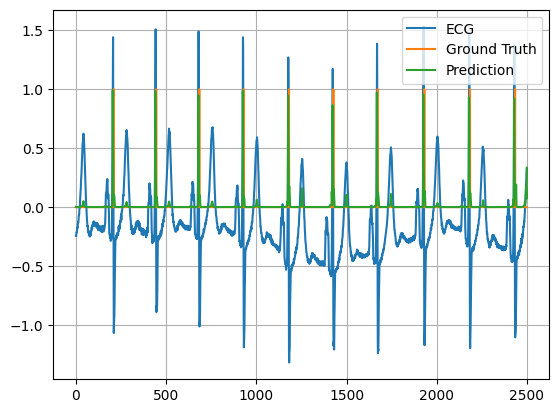

 80%|███████▉  | 2214/2774 [01:26<00:21, 25.99it/s]

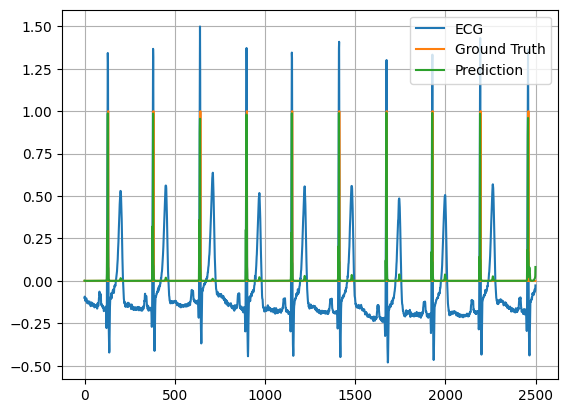

 90%|████████▉ | 2493/2774 [01:37<00:09, 28.42it/s]

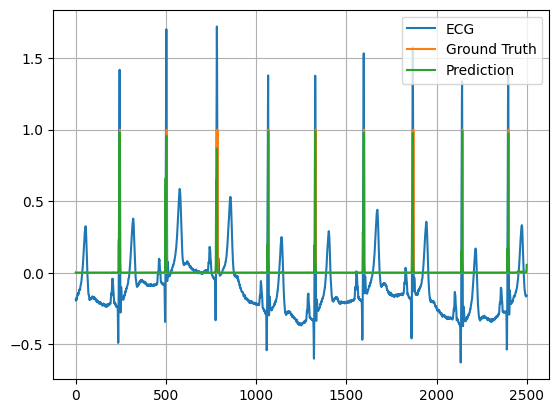

100%|█████████▉| 2770/2774 [01:48<00:00, 27.33it/s]

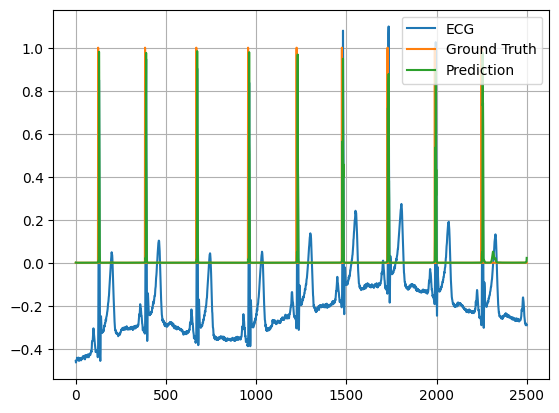

100%|██████████| 2774/2774 [01:48<00:00, 25.51it/s]



Test Loss: 0.2082
test Weighted Accuracy: 0.73834
test F1 Score: 0.54844
test TPR: 0.47775
test FPR: 0.00107
test TNR: 0.99893
test FNR: 0.52225



In [ ]:
# test_model(raw_lstm, x_raw, y_raw, plot=True)
raw_lstm.test_model(x_raw, y_raw, plot=True)

### test with own ecgs

In [ ]:
def test_model(model, x_test, y_test, plot=False):
    test_dataset = ECGDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    running_loss = 0.0
    num_r_peaks = 0.0
    num_correct = 0.0

    all_outputs = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for i, (x_test, y_test) in tqdm(enumerate(test_loader), total=len(test_loader)):
            x, y = x_test.to(device), y_test.to(device)
            outputs = model(x)

            loss = model.criterion(outputs, y)
            running_loss += loss.item()

            outputs = torch.sigmoid(outputs)

            outputs = outputs.cpu().detach().numpy()
            y = y.cpu().detach().numpy()

            num_r_peaks += np.where(y == 1)[0].shape[0]
            num_correct += np.where((outputs > 0.5) & (y == 1))[0].shape[0]

            all_outputs.extend(outputs.flatten())
            all_labels.extend(y.flatten())

            ecg = x[0].cpu().detach().numpy().flatten()
            gt = y[0].flatten()
            pred = outputs[0].flatten()
            temp = np.copy(pred)

            pred = (pred > 0.5).astype(np.int32)

            corrected_r_peaks = correct_prediction_according_to_aami(y_true=gt, y_pred=pred, sampling_rate=250)

            correct_r_peaks = np.where((corrected_r_peaks == 1) & (gt == 1))[0]
            false_positives = np.where((corrected_r_peaks == 1) & (gt == 0))[0]
            false_negatives = np.where((corrected_r_peaks == 0) & (gt == 1))[0]

            if (len(false_positives) > 0 or len(false_negatives) > 0) and plot == True:
                plt.plot(temp)
                plt.grid()
                plt.title("Przykładowy wektor predykcji")
                plt.show()
                

                print("Sample: ", i)
                print("Correct: ", correct_r_peaks)
                print("FP: ", false_positives)

                gt_line = Line2D([0], [0], color='orange', label='Ground Truth', linestyle='-')
                prediction_line = Line2D([0], [0], color='blue', label='Prediction', linestyle='-')
                correct_line = Line2D([0], [0], color='green', label='Correct line', linestyle='--')
                error_fp = Line2D([0], [0], color='crimson', label='FP', linestyle='--')
                error_fn = Line2D([0], [0], color='darkviolet', label='FN', linestyle='--')

                fig, axs = plt.subplots(nrows=2)
                ax = axs[0]
                ax.plot(ecg)
                ax.legend(["ECG"])
                ax.grid()

                ax = axs[1]
                ax.plot(pred)
                ax.plot(gt)
                ax.grid()
                ax.legend(handles=[gt_line, correct_line, prediction_line, error_fp, error_fn])

                for correct in correct_r_peaks:
                    ax.axvline(correct, 0, 1, color='g', linestyle='--')
                for fp in false_positives:
                    ax.axvline(fp, 0, 1, color='crimson', linestyle='--', linewidth=2)
                for fn in false_negatives:
                    ax.axvline(fn, 0, 1, color='darkviolet', linestyle='--', linewidth=2)

                fig.set_size_inches(6,4)
                plt.show()
            
    all_outputs = np.array(all_outputs)
    all_labels = np.array(all_labels)
    y_pred_binary = (all_outputs > 0.5).astype(int)
    test_loss = running_loss / len(test_loader)
    print(f"\nTest Loss: {test_loss:.4f}")
    model.calculate_metrics(test_loss, all_labels, y_pred_binary, "test")

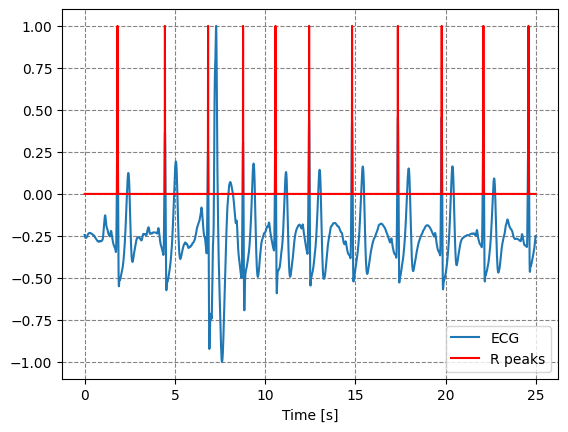

In [ ]:
test_x = x_aidmed[35]
test_y = y_aidmed[35]
plot_ecg(test_x, test_y)

  0%|          | 0/462 [00:00<?, ?it/s]

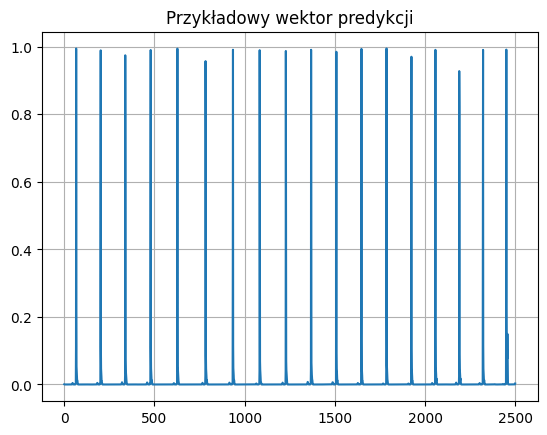

Sample:  0
Correct:  [ 202  339  479  627  784  935 1084 1229 1369 1508 1647 1786 1924 2057
 2190 2321 2450]
FP:  [66]


  1%|          | 3/462 [00:00<01:31,  5.04it/s]

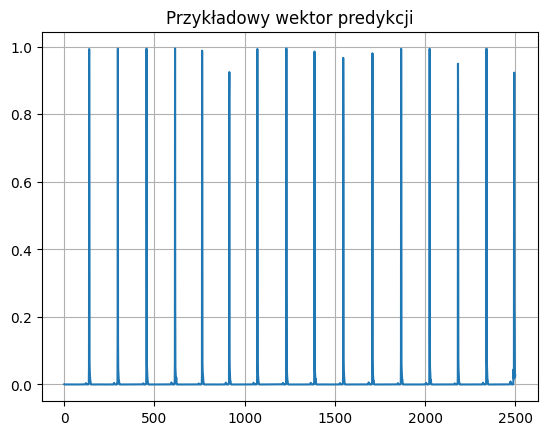

Sample:  3
Correct:  [ 139  297  457  615  765  915 1071 1232 1387 1547 1708 1868 2025 2183
 2340]
FP:  [2493]


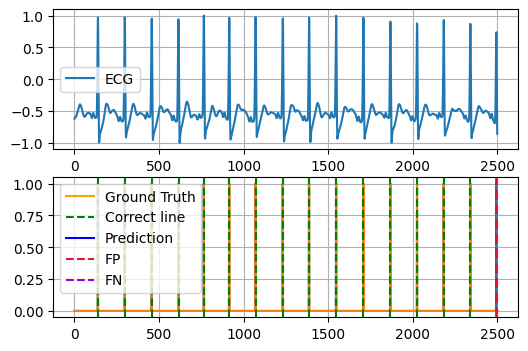

  1%|          | 4/462 [00:01<02:23,  3.19it/s]

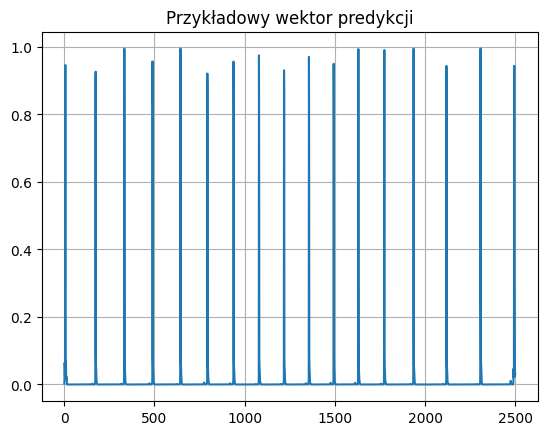

Sample:  6
Correct:  [ 174  334  490  645  794  939 1080 1219 1357 1494 1631 1774 1936 2119
 2307]
FP:  [   6 2493]


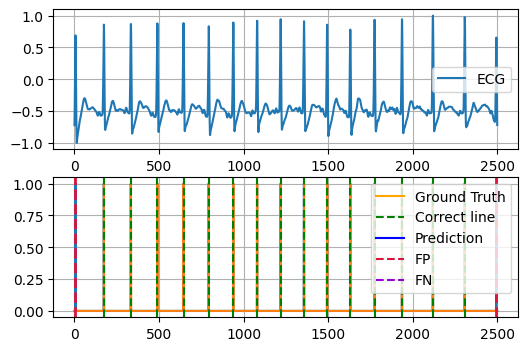

  2%|▏         | 7/462 [00:01<01:39,  4.58it/s]

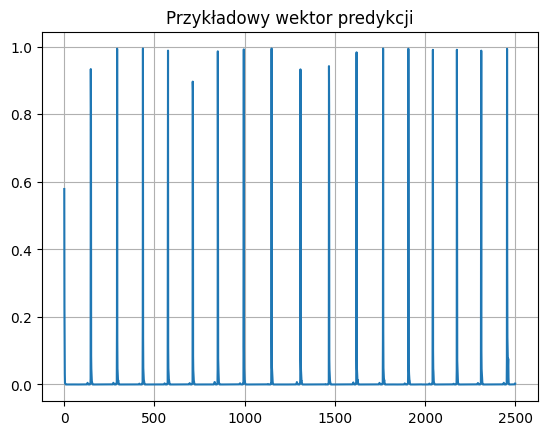

Sample:  9
Correct:  [ 148  293  436  575  713  852  995 1149 1310 1468 1620 1767 1908 2043
 2177 2311 2454]
FP:  [0]


  2%|▏         | 10/462 [00:02<01:32,  4.88it/s]

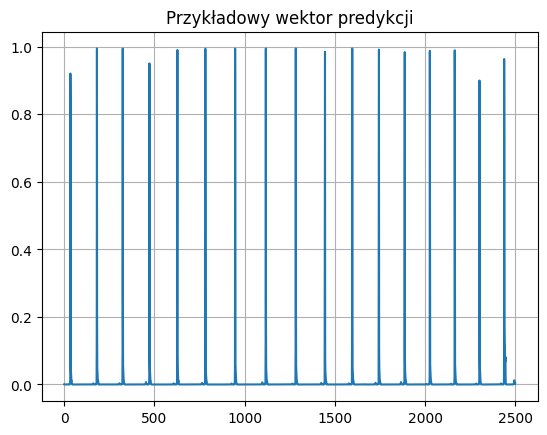

Sample:  13
Correct:  [ 181  324  473  627  783  947 1117 1283 1445 1596 1744 1887 2027 2165
 2302 2439]
FP:  [34]


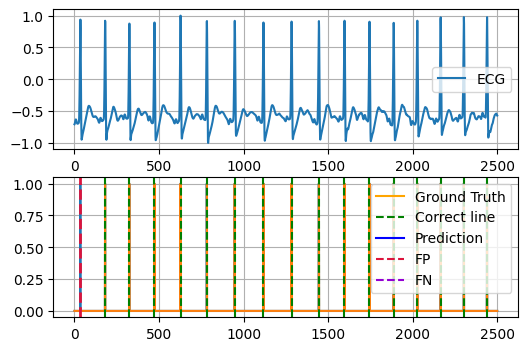

  3%|▎         | 14/462 [00:02<01:14,  6.00it/s]

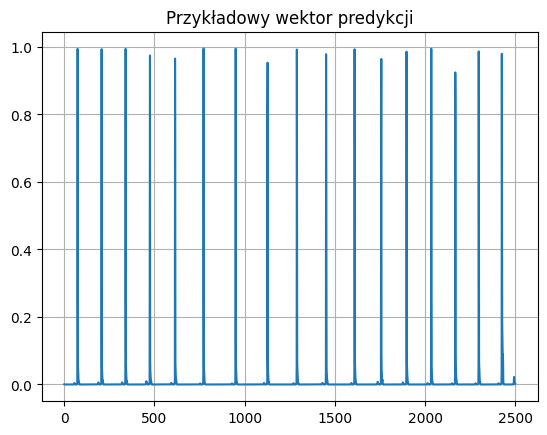

Sample:  14
Correct:  [ 207  340  475  615  772  950 1127 1290 1452 1610 1757 1898 2034 2168
 2298 2426]
FP:  [74]


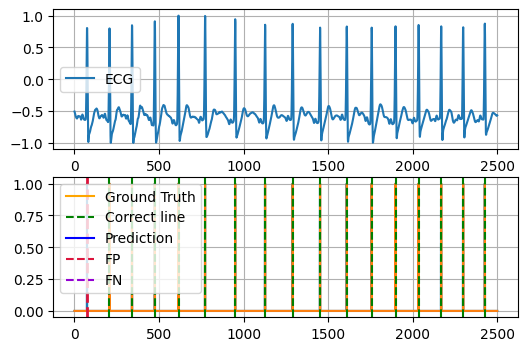

  3%|▎         | 15/462 [00:03<01:34,  4.74it/s]

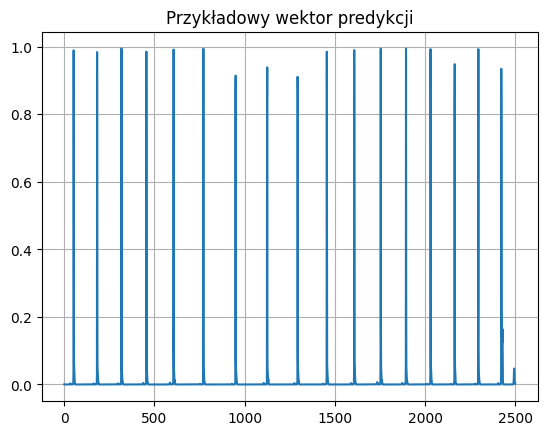

Sample:  15
Correct:  [ 183  317  456  606  771  950 1125 1294 1456 1608 1754 1894 2031 2164
 2295 2423]
FP:  [52]


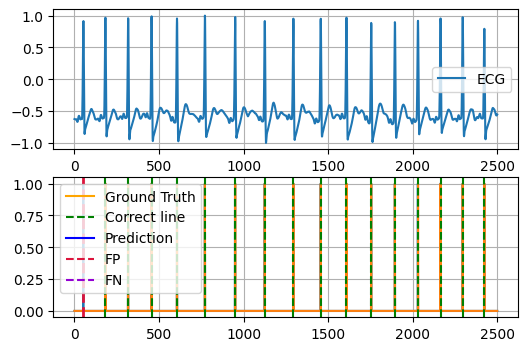

  3%|▎         | 16/462 [00:03<01:59,  3.74it/s]

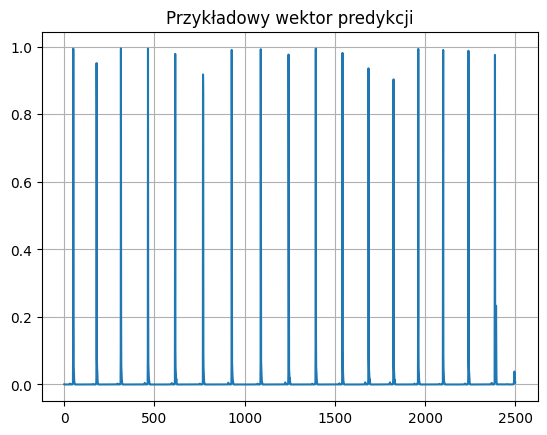

Sample:  16
Correct:  [ 180  314  465  615  770  929 1090 1244 1394 1542 1687 1825 1962 2100
 2241 2387]
FP:  [50]


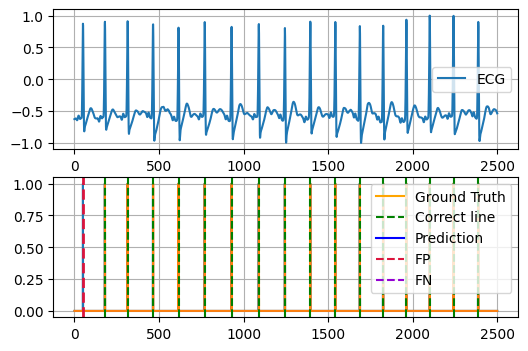

  4%|▎         | 17/462 [00:04<02:17,  3.23it/s]

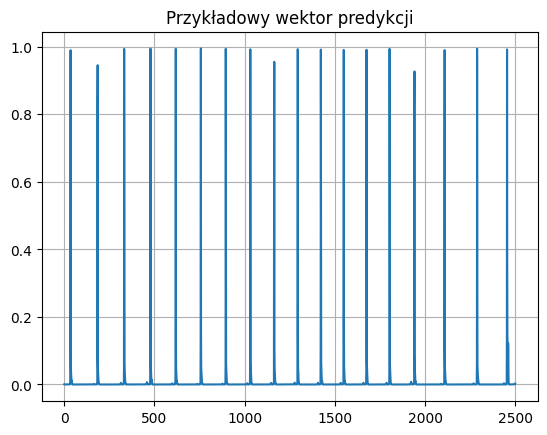

Sample:  17
Correct:  [ 185  333  478  618  757  896 1032 1164 1294 1423 1549 1676 1803 1941
 2108 2289 2455]
FP:  [35]


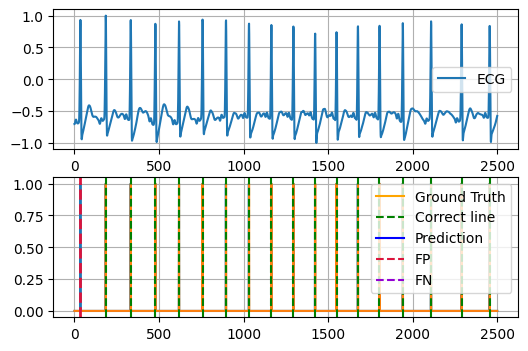

  4%|▍         | 18/462 [00:04<02:30,  2.96it/s]

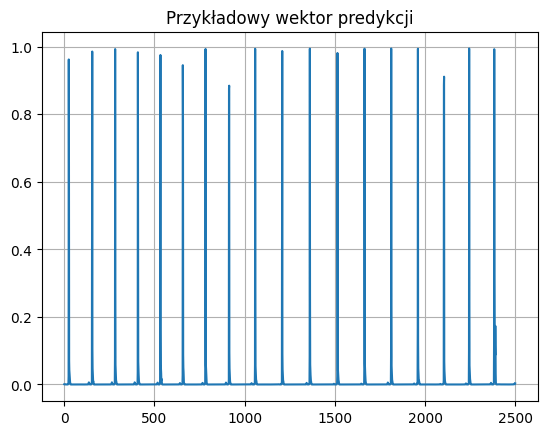

Sample:  18
Correct:  [ 155  282  409  533  658  783  914 1058 1208 1361 1515 1665 1812 1960
 2105 2245 2383]
FP:  [25]


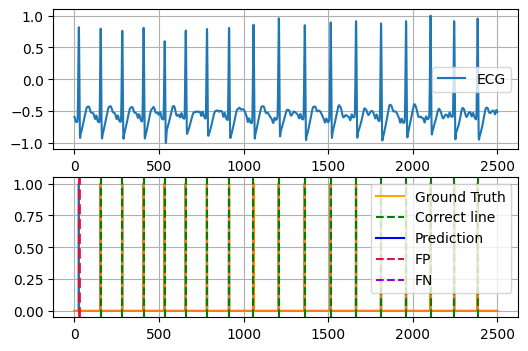

  4%|▍         | 19/462 [00:05<02:40,  2.77it/s]

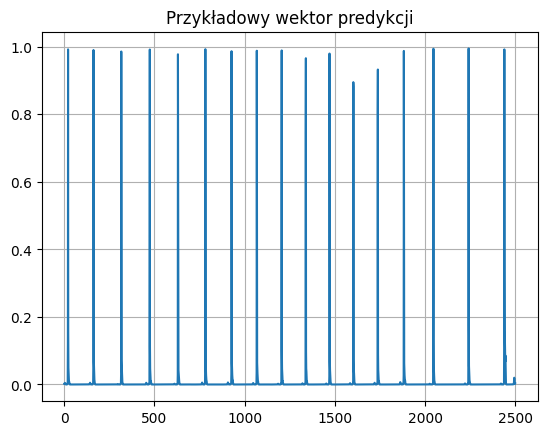

Sample:  19
Correct:  [ 162  317  474  631  783  928 1068 1205 1339 1471 1603 1738 1883 2046
 2241 2439]
FP:  [21]


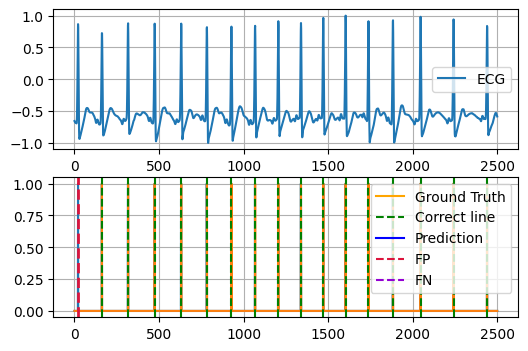

  5%|▍         | 23/462 [00:05<01:30,  4.84it/s]

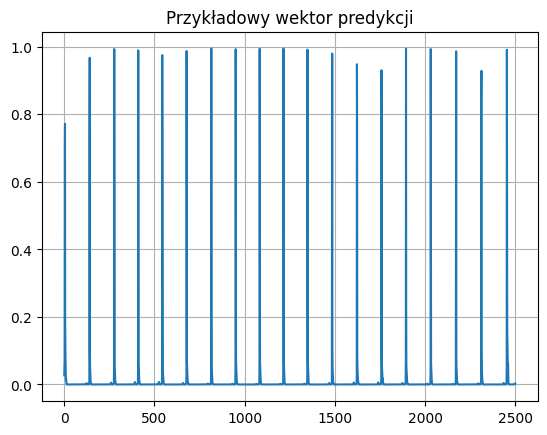

Sample:  24
Correct:  [ 141  277  411  544  679  815  951 1084 1216 1349 1485 1623 1759 1894
 2032 2172 2312 2454]
FP:  [3]


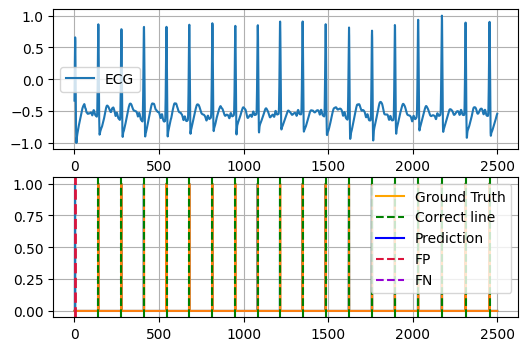

  5%|▌         | 25/462 [00:06<01:34,  4.63it/s]

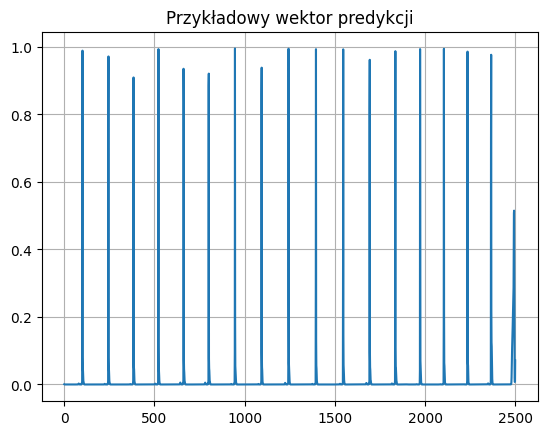

Sample:  26
Correct:  [ 101  245  384  522  662  801  946 1094 1243 1395 1546 1693 1835 1973
 2104 2235 2366]
FP:  [2492]


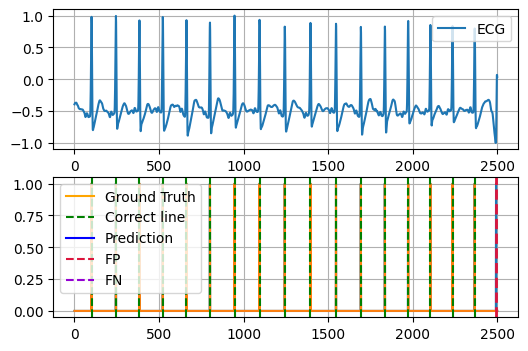

  7%|▋         | 31/462 [00:06<00:55,  7.72it/s]

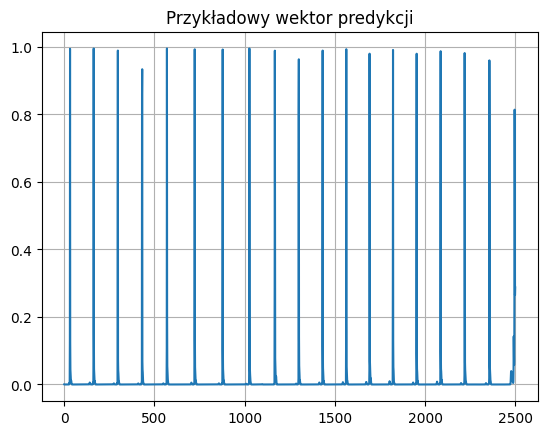

Sample:  31
Correct:  [ 163  297  432  569  723  878 1027 1168 1300 1432 1563 1693 1822 1953
 2086 2220 2357]
FP:  [  32 2496]


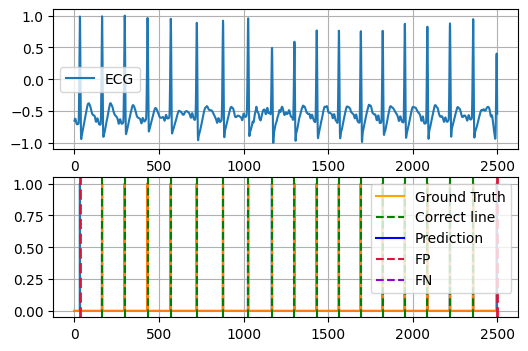

  7%|▋         | 33/462 [00:07<01:07,  6.40it/s]

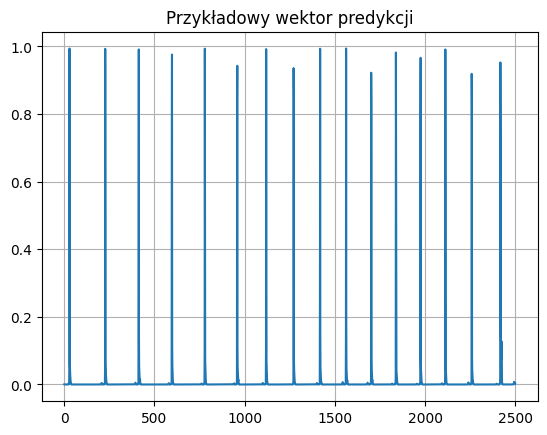

Sample:  33
Correct:  [ 228  413  597  779  959 1119 1272 1418 1562 1702 1839 1975 2113 2259
 2418]
FP:  [29]


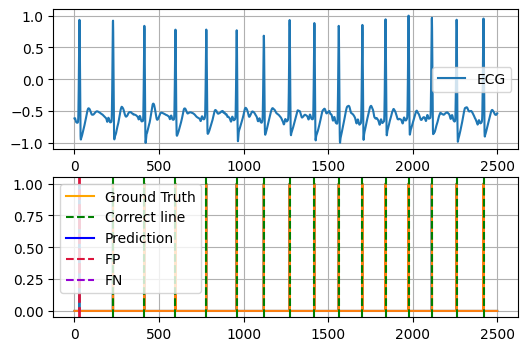

  8%|▊         | 35/462 [00:07<01:14,  5.70it/s]

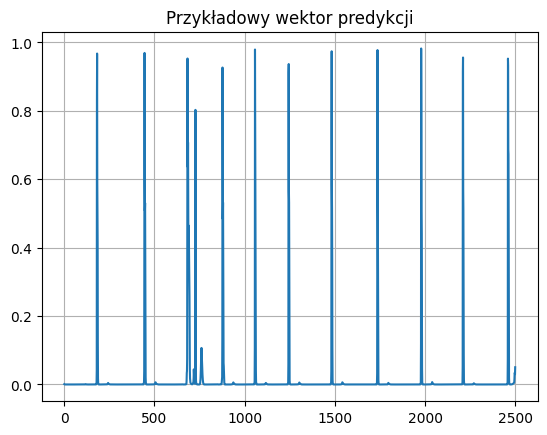

Sample:  35
Correct:  [ 182  445  684  878 1058 1244 1482 1736 1979 2210 2460]
FP:  [727 880]


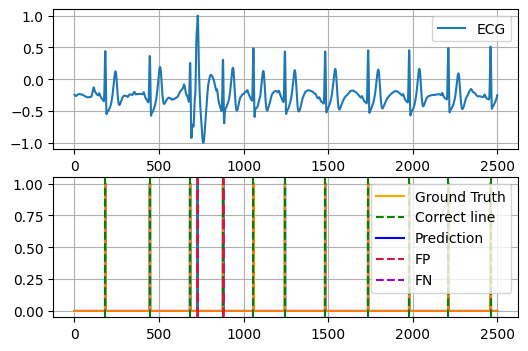

  8%|▊         | 36/462 [00:08<01:32,  4.60it/s]

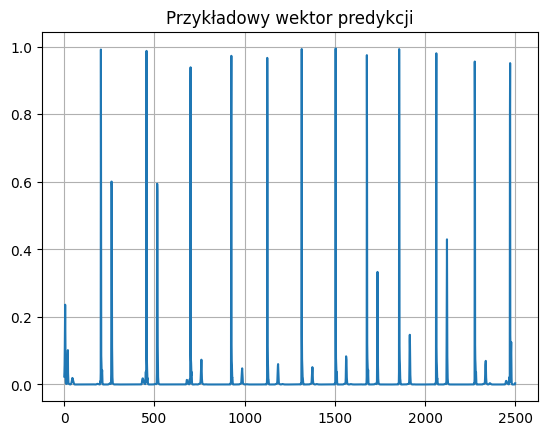

Sample:  36
Correct:  [ 204  456  700  926 1126 1316 1504 1678 1857 2062 2276 2471]
FP:  [262 515]


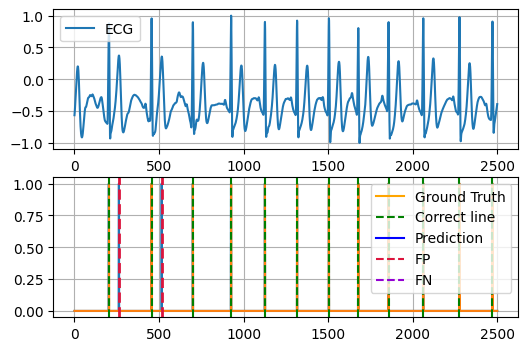

  8%|▊         | 37/462 [00:08<01:47,  3.97it/s]

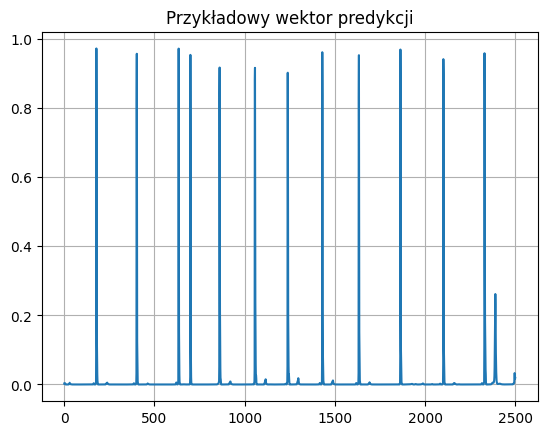

Sample:  37
Correct:  [ 179  402  635  861 1057 1239 1431 1633 1864 2102 2330]
FP:  [699]


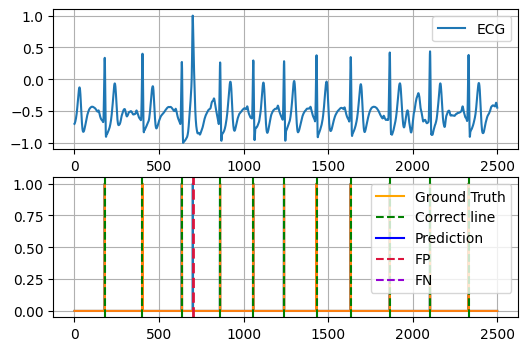

  8%|▊         | 38/462 [00:08<02:02,  3.46it/s]

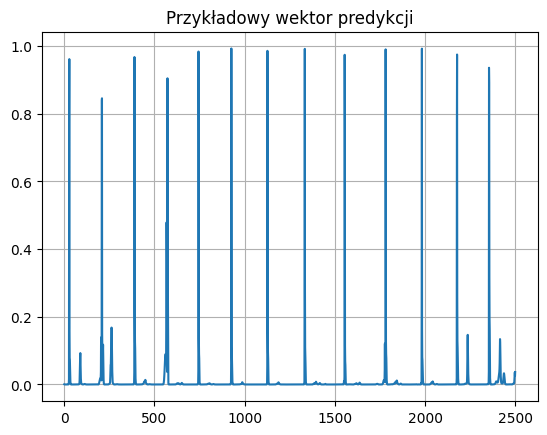

Sample:  38
Correct:  [ 208  390  572  745  927 1127 1333 1555 1781 1982 2177 2355]
FP:  [27]


  8%|▊         | 39/462 [00:09<02:14,  3.14it/s]

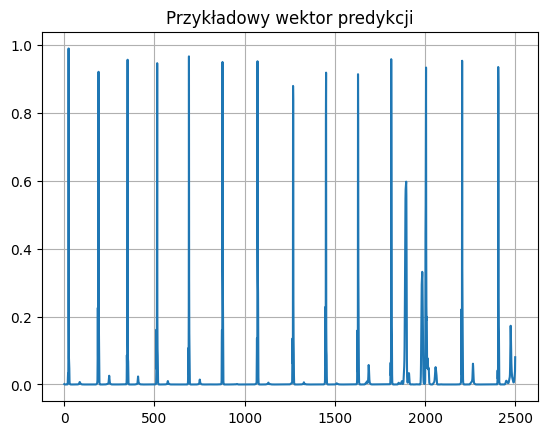

Sample:  39
Correct:  [ 190  351  515  691  877 1072 1269 1451 1629 1813 2006 2205 2406]
FP:  [  24 1893]


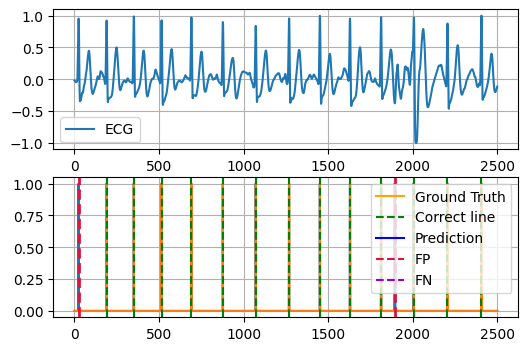

  9%|▊         | 40/462 [00:10<03:03,  2.30it/s]

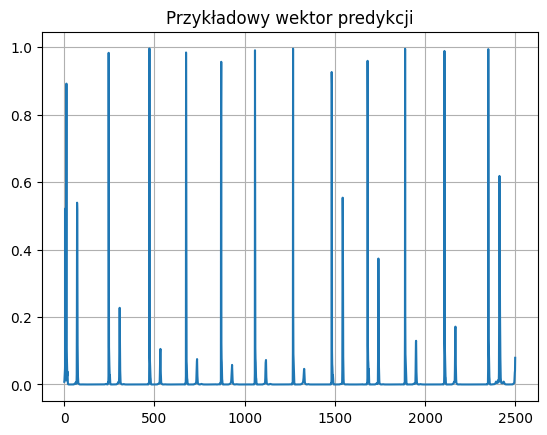

Sample:  41
Correct:  [ 247  472  676  870 1058 1268 1483 1682 1889 2108 2351]
FP:  [   7   11   71 1543 2412]


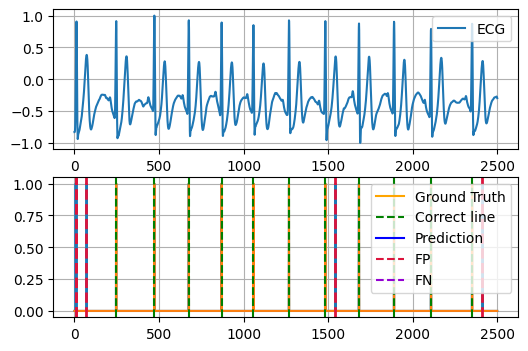

  9%|▉         | 42/462 [00:10<02:32,  2.76it/s]

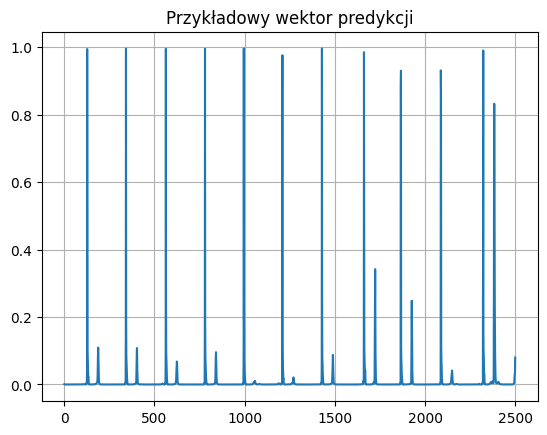

Sample:  43
Correct:  [ 128  342  563  780  995 1209 1428 1662 1866 2088 2322]
FP:  [2383]


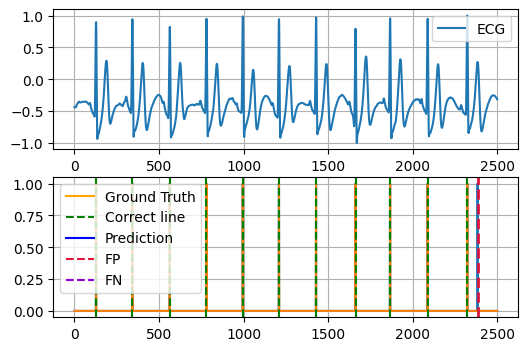

 10%|▉         | 44/462 [00:11<02:10,  3.20it/s]

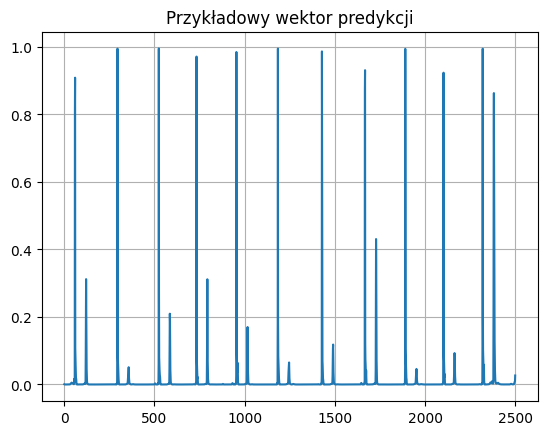

Sample:  44
Correct:  [ 295  524  733  955 1184 1429 1667 1891 2102 2319]
FP:  [  59 2381]


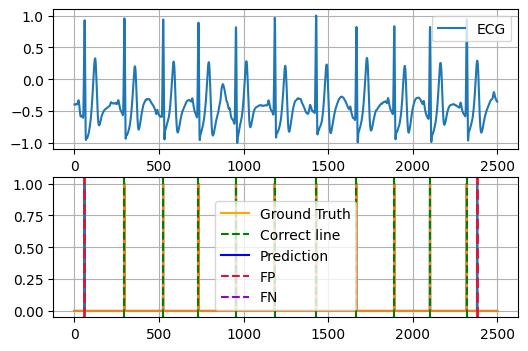

 10%|▉         | 45/462 [00:11<02:19,  2.98it/s]

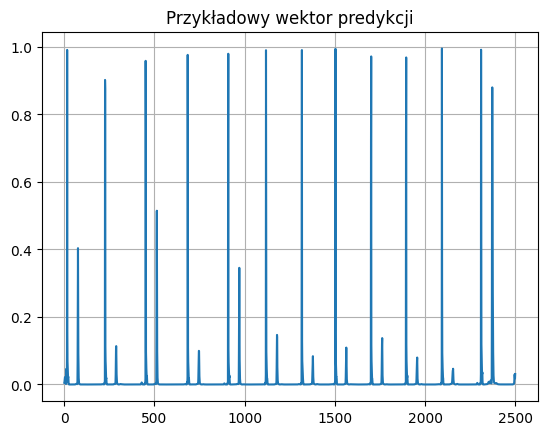

Sample:  45
Correct:  [ 227  452  685  909 1119 1317 1503 1701 1895 2094 2311]
FP:  [  16  513 2372]


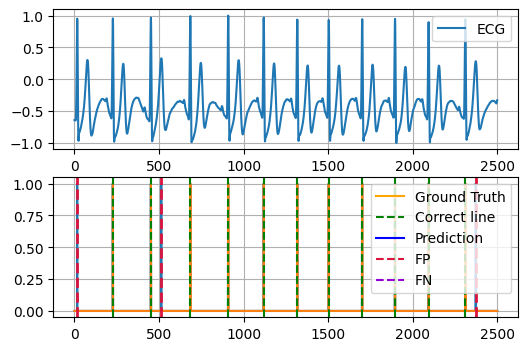

 10%|▉         | 46/462 [00:12<02:29,  2.79it/s]

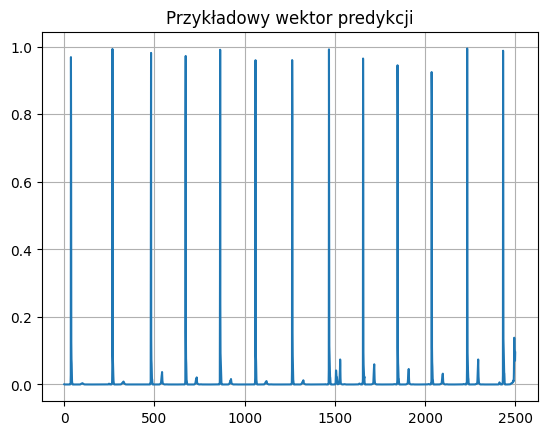

Sample:  46
Correct:  [ 268  481  673  864 1060 1264 1468 1657 1848 2037 2234 2433]
FP:  [37]


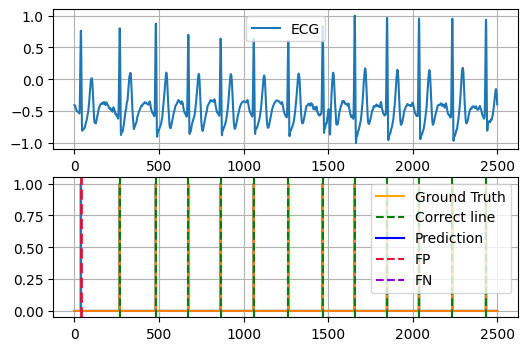

 10%|█         | 47/462 [00:12<02:37,  2.64it/s]

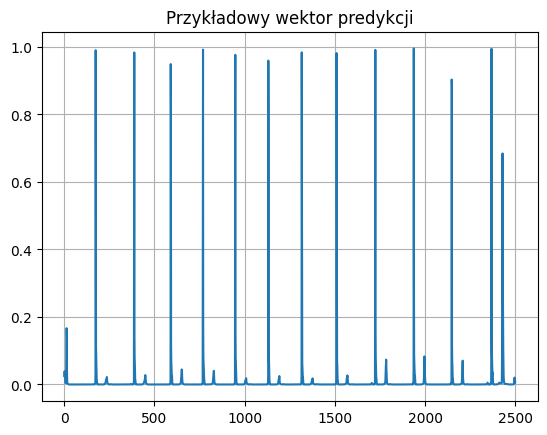

Sample:  48
Correct:  [ 175  388  591  769  948 1132 1317 1510 1724 1938 2148 2368]
FP:  [2428]


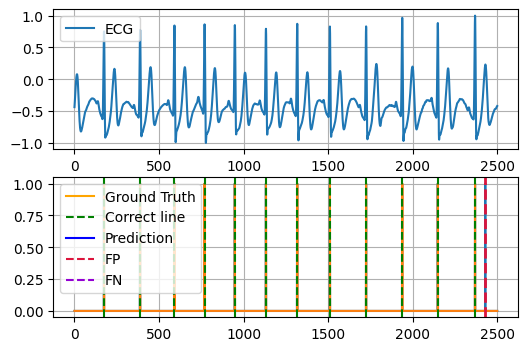

 11%|█         | 49/462 [00:13<02:19,  2.95it/s]

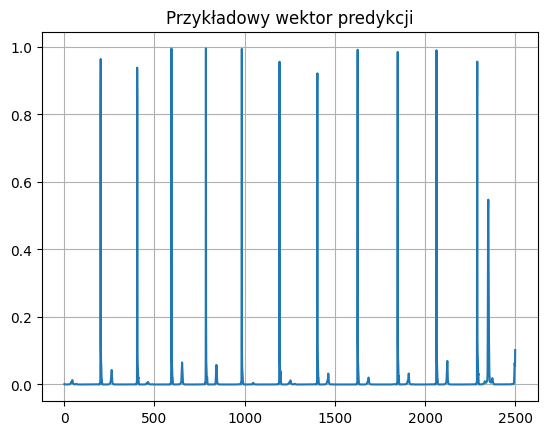

Sample:  50
Correct:  [ 202  405  594  785  984 1193 1403 1626 1848 2063 2289]
FP:  [2349]


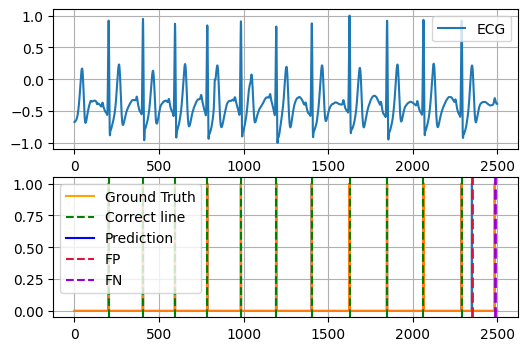

 11%|█         | 51/462 [00:13<02:06,  3.25it/s]

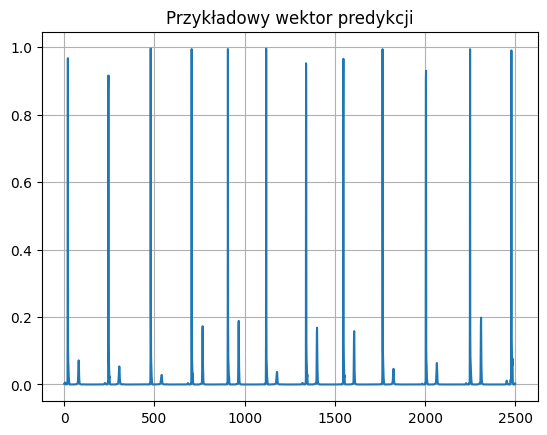

Sample:  51
Correct:  [ 245  480  706  907 1119 1341 1547 1765 2005 2249 2478]
FP:  [19]


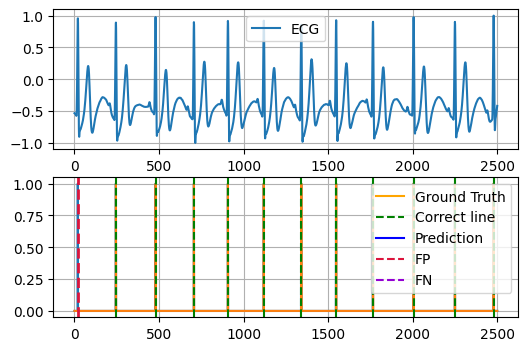

 11%|█▏        | 52/462 [00:13<02:15,  3.02it/s]

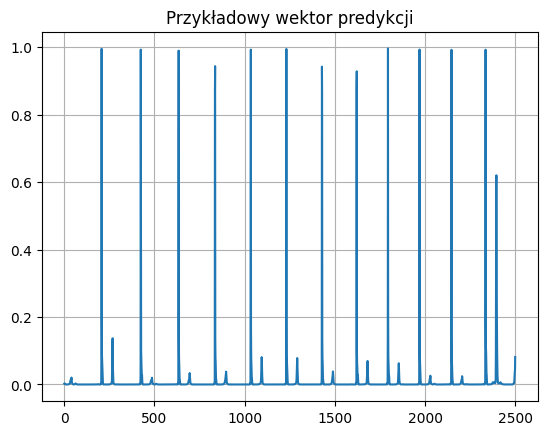

Sample:  52
Correct:  [ 207  425  634  836 1034 1231 1429 1621 1794 1969 2146 2335]
FP:  [2394]


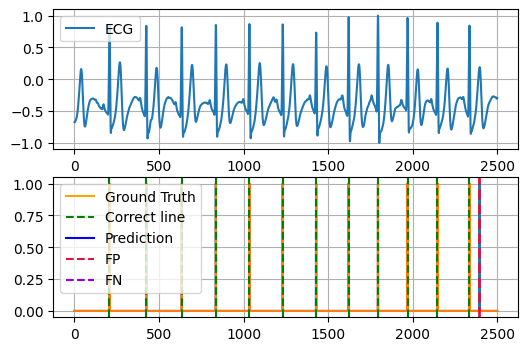

 11%|█▏        | 53/462 [00:14<02:28,  2.75it/s]

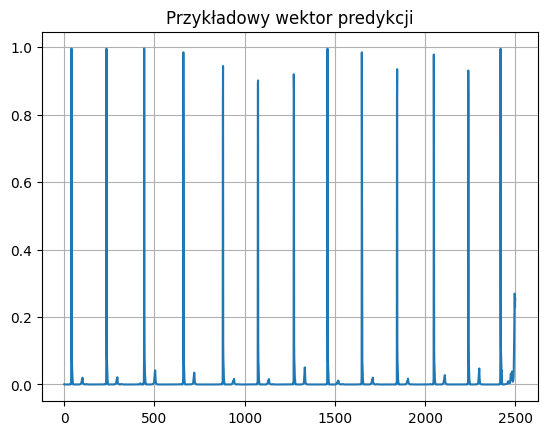

Sample:  53
Correct:  [ 234  443  661  880 1074 1273 1459 1650 1845 2049 2240 2419]
FP:  [40]


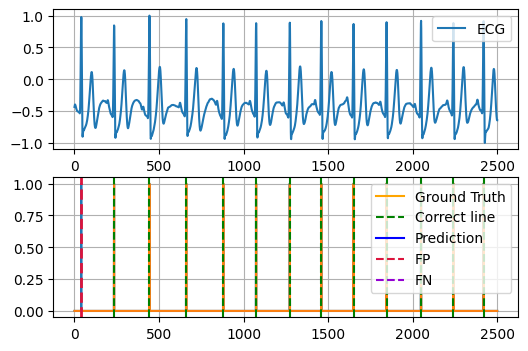

 12%|█▏        | 54/462 [00:14<02:43,  2.50it/s]

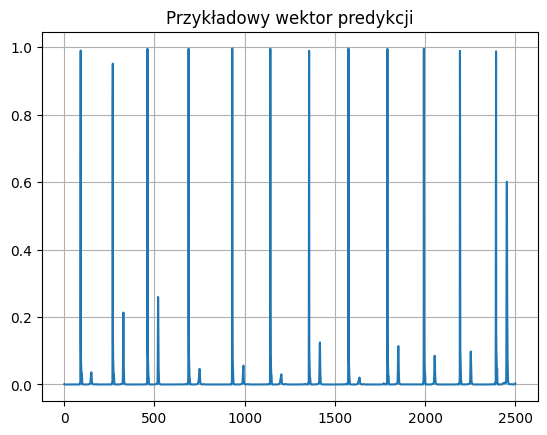

Sample:  54
Correct:  [  91  269  461  689  931 1142 1357 1575 1791 1993 2194 2393]
FP:  [2452]


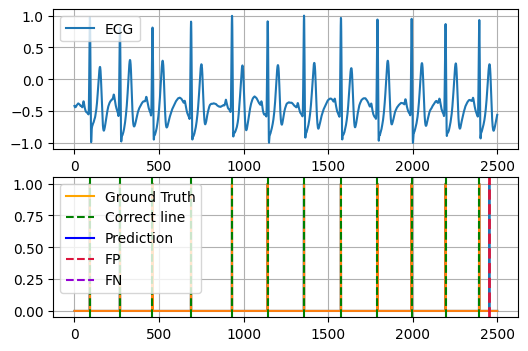

 12%|█▏        | 55/462 [00:15<02:47,  2.42it/s]

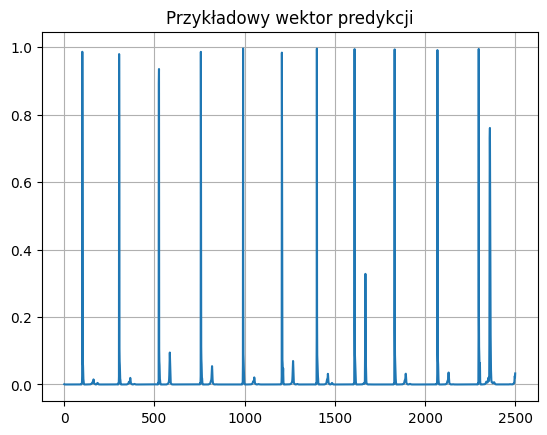

Sample:  55
Correct:  [ 101  305  525  758  992 1207 1400 1609 1831 2069 2297]
FP:  [2359]


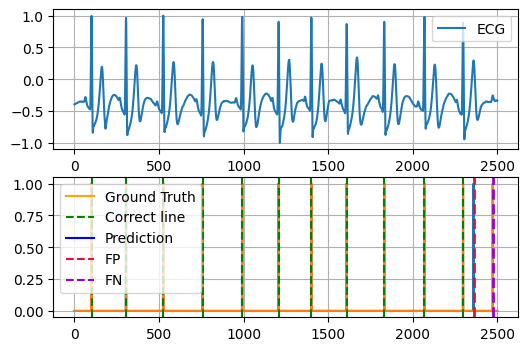

 12%|█▏        | 56/462 [00:15<02:52,  2.36it/s]

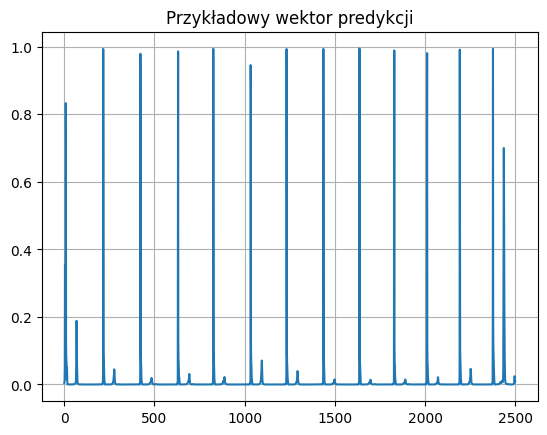

Sample:  56
Correct:  [ 217  423  631  827 1034 1233 1437 1636 1829 2011 2193 2376]
FP:  [   8 2436]


 12%|█▏        | 57/462 [00:16<02:56,  2.30it/s]

Sample:  57
Correct:  [ 248  447  647  840 1035 1241 1455 1669 1867 2056 2239 2416]
FP:  [61]


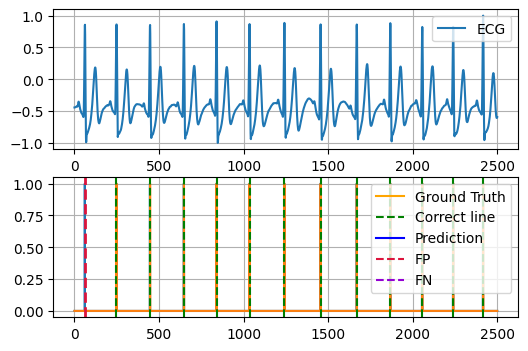

 13%|█▎        | 62/462 [00:17<01:17,  5.19it/s]

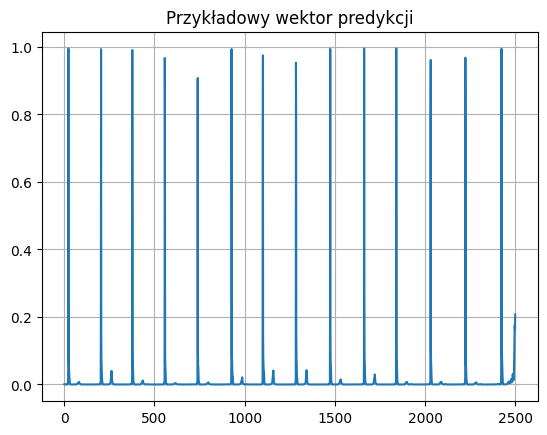

Sample:  62
Correct:  [ 204  378  558  740  928 1101 1285 1474 1662 1841 2031 2224 2423]
FP:  [23]


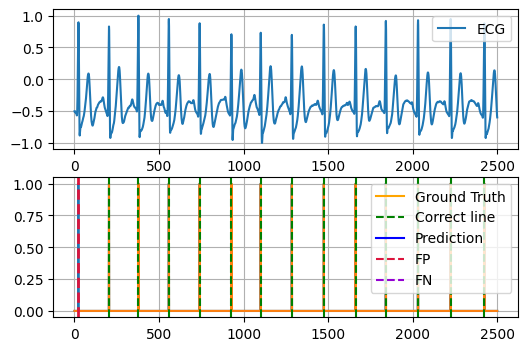

 14%|█▎        | 63/462 [00:17<01:34,  4.22it/s]

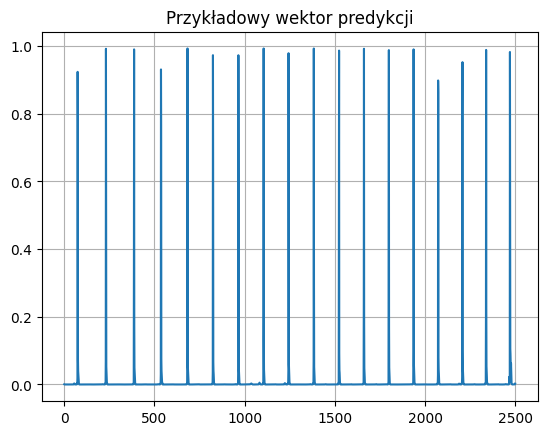

Sample:  65
Correct:  [ 231  387  537  683  825  966 1105 1243 1383 1523 1661 1799 1936 2073
 2207 2338 2470]
FP:  [74]


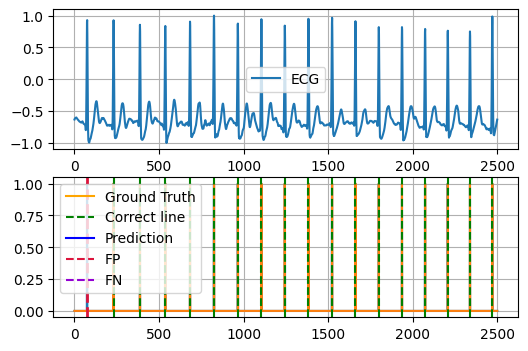

 14%|█▍        | 66/462 [00:17<01:20,  4.90it/s]

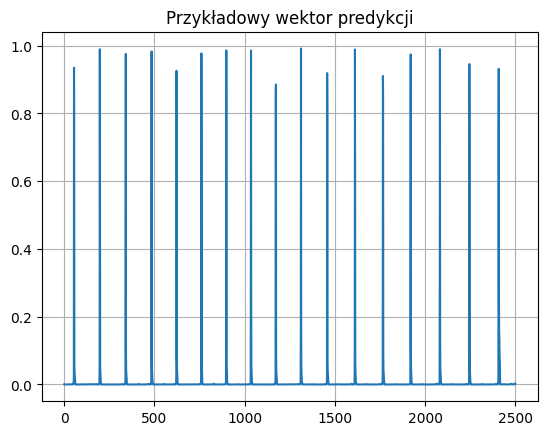

Sample:  67
Correct:  [ 197  341  484  623  760  898 1035 1173 1312 1458 1611 1767 1920 2082
 2246 2408]
FP:  [54]


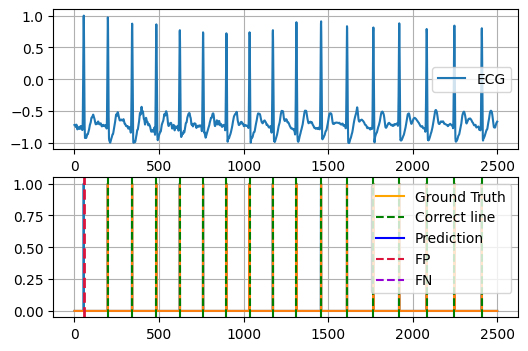

 15%|█▍        | 68/462 [00:18<01:22,  4.80it/s]

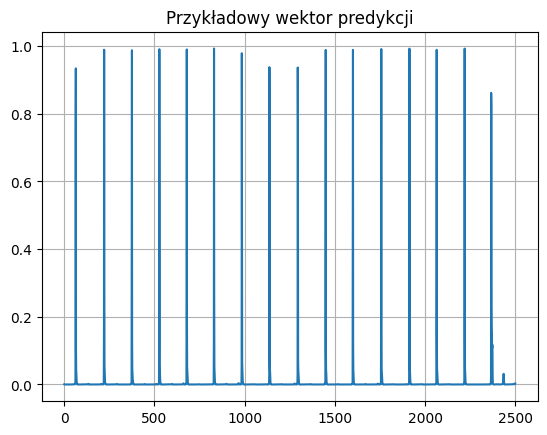

Sample:  68
Correct:  [ 221  375  527  679  830  984 1138 1295 1449 1600 1757 1913 2064 2219
 2367]
FP:  [63]


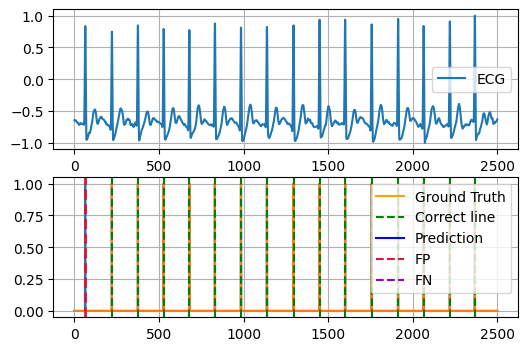

 15%|█▍        | 69/462 [00:18<01:38,  3.98it/s]

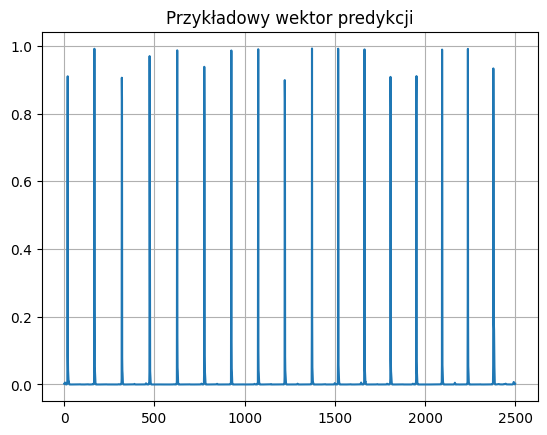

Sample:  69
Correct:  [ 167  320  473  626  777  926 1075 1223 1373 1518 1664 1809 1952 2094
 2237 2379]
FP:  [18]


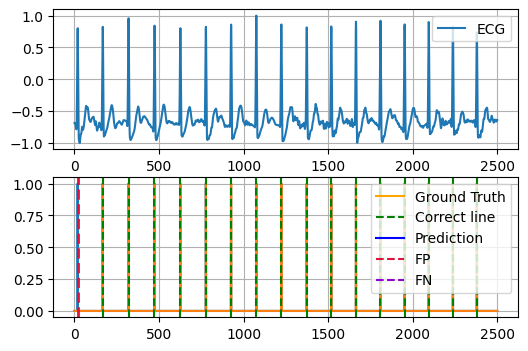

 15%|█▌        | 70/462 [00:19<01:54,  3.42it/s]

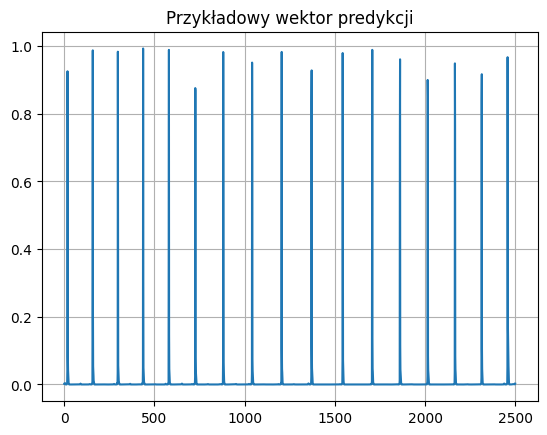

Sample:  70
Correct:  [ 158  297  437  580  727  881 1042 1205 1371 1543 1707 1861 2015 2166
 2314 2457]
FP:  [18]


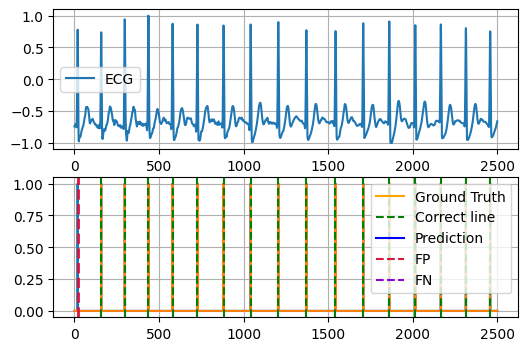

 16%|█▌        | 74/462 [00:19<01:13,  5.24it/s]

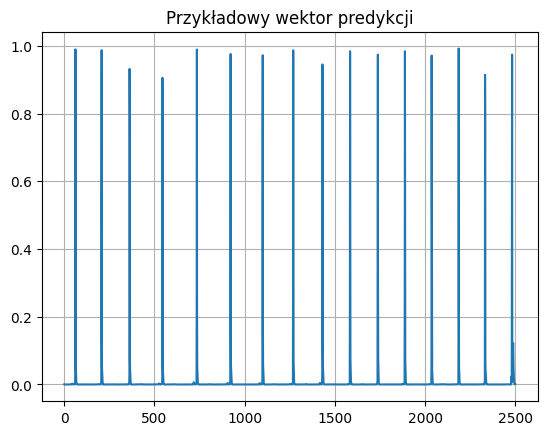

Sample:  74
Correct:  [ 207  363  545  735  922 1100 1269 1432 1584 1738 1888 2037 2186 2333
 2482]
FP:  [62]


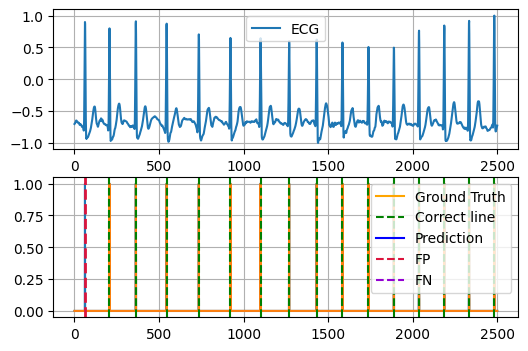

 17%|█▋        | 78/462 [00:20<00:56,  6.77it/s]

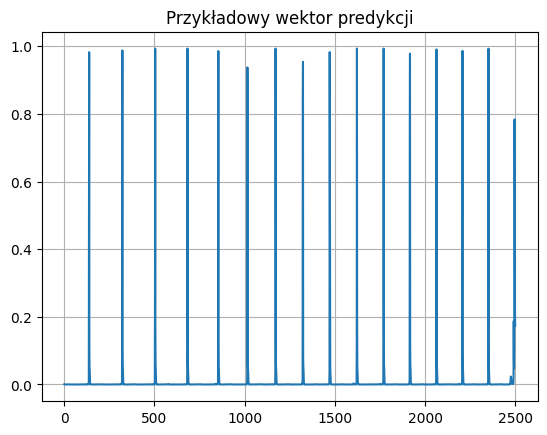

Sample:  78
Correct:  [ 138  322  504  683  854 1016 1171 1323 1472 1622 1770 1916 2063 2207
 2351]
FP:  [2495]


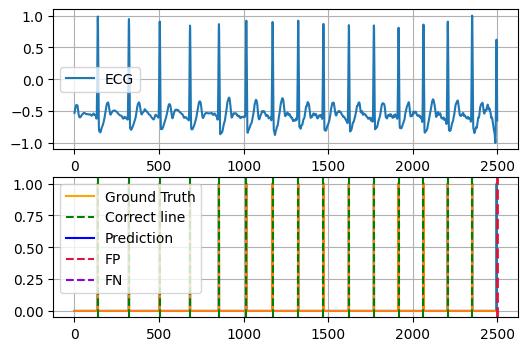

 17%|█▋        | 80/462 [00:20<01:04,  5.93it/s]

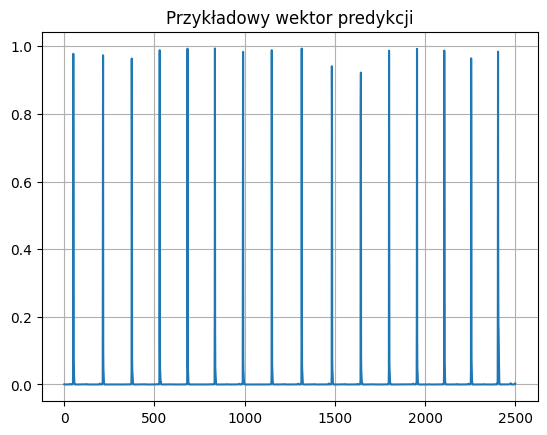

Sample:  81
Correct:  [ 215  375  529  683  835  991 1150 1316 1484 1644 1800 1955 2106 2256
 2404]
FP:  [50]


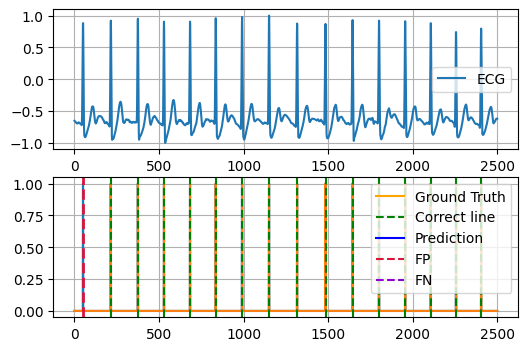

 18%|█▊        | 82/462 [00:21<01:29,  4.24it/s]

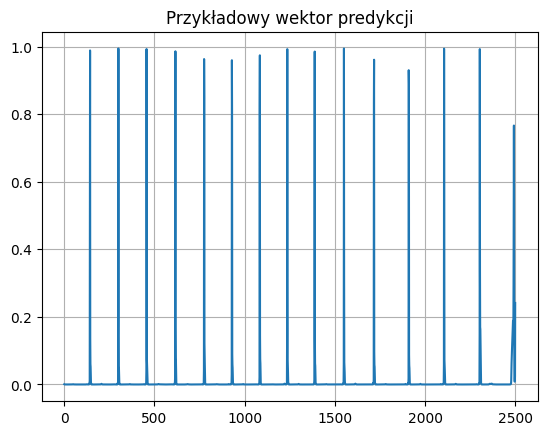

Sample:  82
Correct:  [ 143  300  456  616  776  930 1084 1236 1388 1550 1717 1910 2105 2303]
FP:  [2492]


 18%|█▊        | 83/462 [00:22<01:42,  3.70it/s]

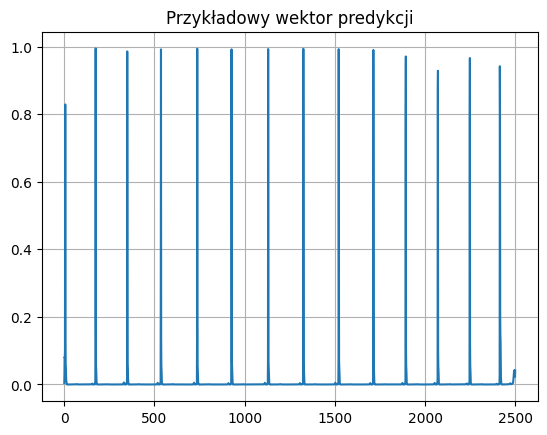

Sample:  85
Correct:  [ 174  349  536  737  927 1130 1325 1521 1713 1893 2071 2248 2415]
FP:  [5]


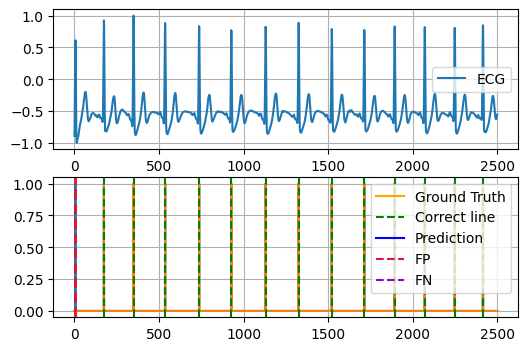

 19%|█▊        | 86/462 [00:22<01:22,  4.55it/s]

Sample:  86
Correct:  [ 231  389  546  700  853 1012 1180 1347 1522 1700 1875 2036 2190 2344]
FP:  [73]


 19%|█▉        | 87/462 [00:22<01:34,  3.96it/s]

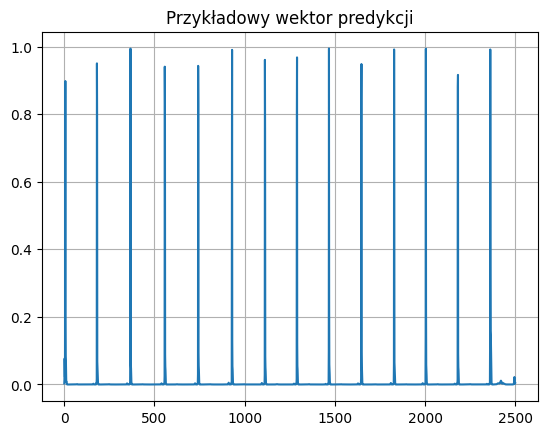

Sample:  87
Correct:  [ 182  367  558  743  930 1113 1290 1467 1647 1828 2004 2182 2361]
FP:  [6]


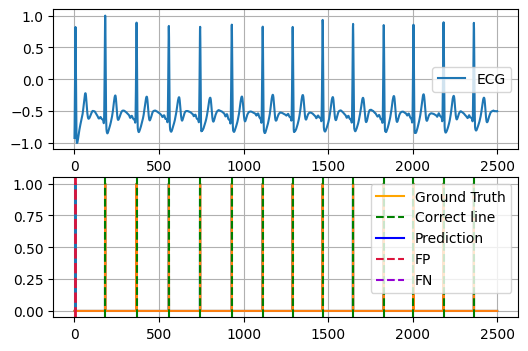

 19%|█▉        | 88/462 [00:23<01:47,  3.49it/s]

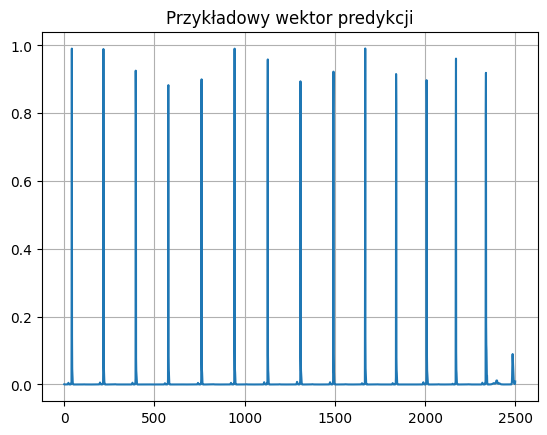

Sample:  88
Correct:  [ 217  397  577  761  944 1128 1310 1492 1668 1840 2009 2171 2337]
FP:  [42]


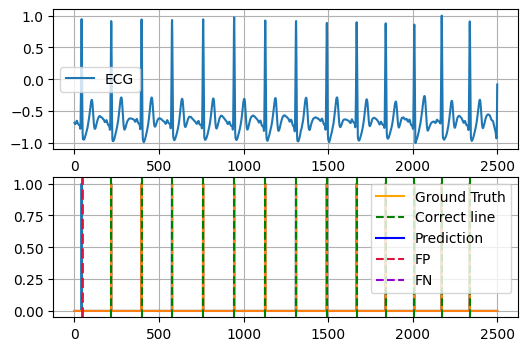

 19%|█▉        | 89/462 [00:23<02:02,  3.03it/s]

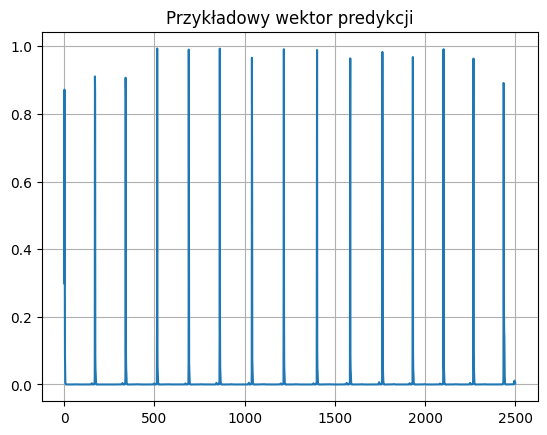

Sample:  89
Correct:  [ 171  341  515  690  862 1041 1217 1401 1585 1763 1932 2102 2268 2436]
FP:  [1]


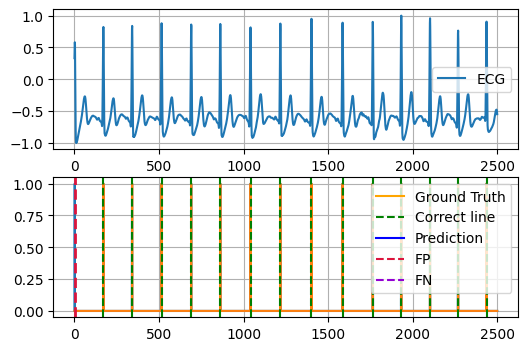

 19%|█▉        | 90/462 [00:24<02:16,  2.73it/s]

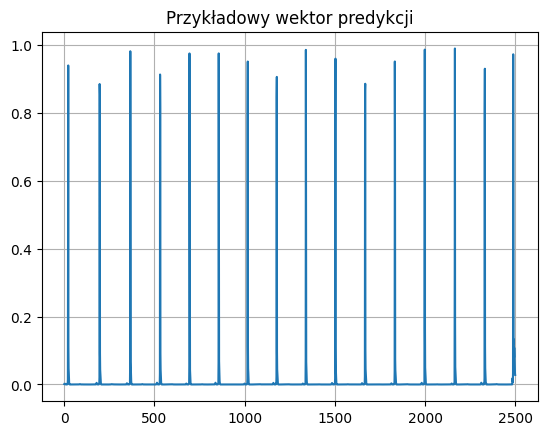

Sample:  92
Correct:  [ 197  366  532  695  856 1017 1178 1339 1503 1668 1833 1998 2165 2331
 2489]
FP:  [21]


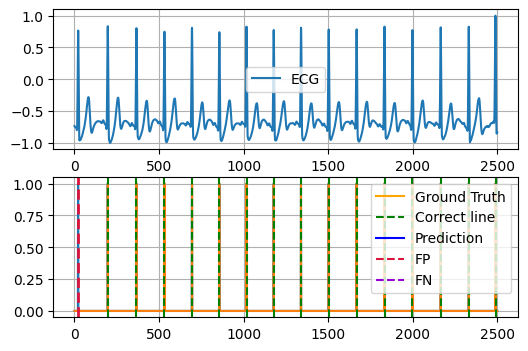

 21%|██        | 96/462 [00:25<01:05,  5.59it/s]

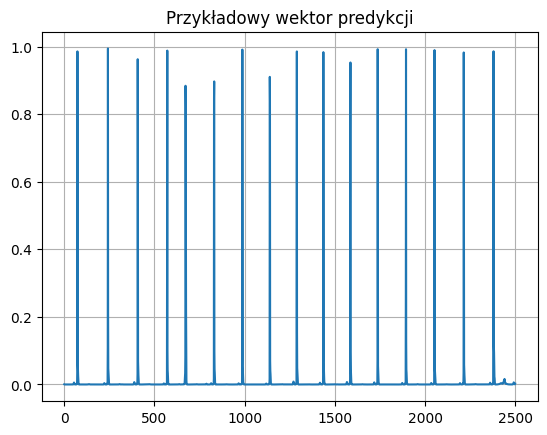

Sample:  98
Correct:  [ 242  407  571  673  831  987 1140 1289 1436 1586 1737 1894 2052 2214
 2379]
FP:  [73]


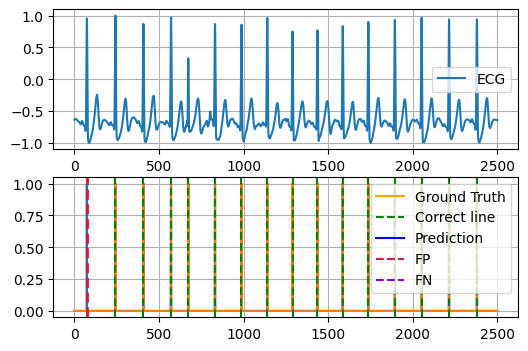

 21%|██▏       | 99/462 [00:25<01:01,  5.86it/s]

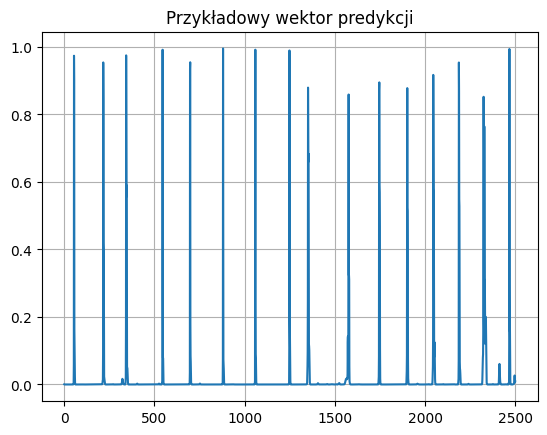

Sample:  99
Correct:  [ 217  344  545  698  880 1059 1248 1352 1576 1746 1901 2046 2188 2328
 2467]
FP:  [54]


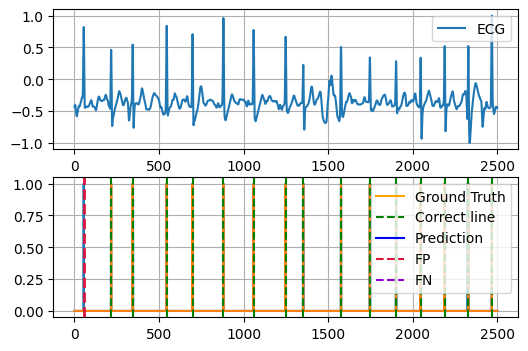

 22%|██▏       | 100/462 [00:25<01:15,  4.78it/s]

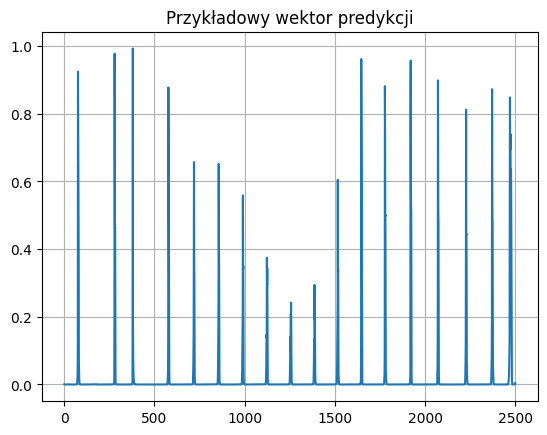

Sample:  100
Correct:  [  77  279  381  578  719  856  990 1517 1647 1778 1920 2072 2227 2372
 2470]
FP:  [1780]


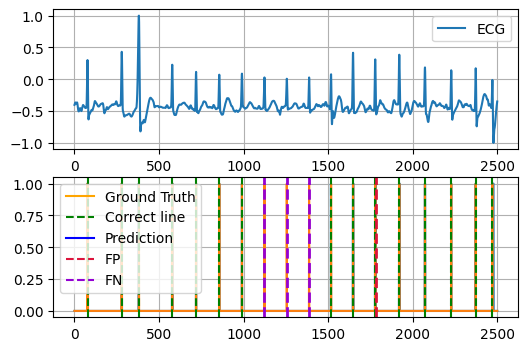

 22%|██▏       | 101/462 [00:26<01:30,  4.01it/s]

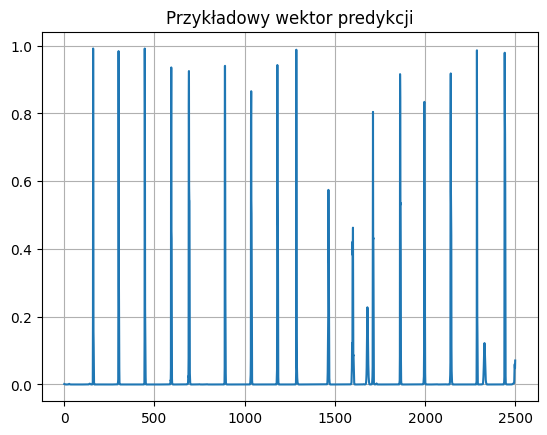

 22%|██▏       | 101/462 [00:26<01:35,  3.79it/s]

Sample:  101
Correct:  [ 160  301  447  593  691  891 1036 1182 1287 1464 1711 1862 1996 2142
 2287 2441]
FP:  []


KeyboardInterrupt: 

In [ ]:
test_model(raw_lstm, x_aidmed, y_aidmed, True)